<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Preprocessing_of_datasets_Environmental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import boxcox
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
sns.set()

In [4]:
!pip install -q pymer4

     |████████████████████████████████| 59 kB 2.9 MB/s 
     |████████████████████████████████| 194 kB 9.4 MB/s 


In [5]:
from pymer4.models import Lmer
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [6]:

!pip install -q statsmodels

In [7]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.2.20221110-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


(as ‘lib’ is unspecified)
































































	‘/tmp/RtmpfV8GAL/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7ff8d8d9d370> [RTYPES.NILSXP]

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R 
library(lme4)
library(lmerTest)


Attaching package: ‘lmerTest’



    lmer



    step




In [10]:
working_path = Path('/content/gdrive/MyDrive/CoganLab/Environmental')

In [11]:
!ls /content/gdrive/MyDrive/CoganLab/Environmental

 D29_Block_1_TrialData.mat	 'D77_Block_1_TrialData (1).mat'
 D64_Block_1_TrialData.mat	  eeg_envir.csv
 D65_Block_1_TrialData_1.mat	  Environmental_Subject.mat
 D65_Block_1_TrialData.mat	  healthy
'D71_Block_1_TrialData (1).mat'   ieeg_envir.csv
'D73_Block_1_TrialData (2).mat'   stimuli


In [12]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_envir.csv'),
    index_col=None
)
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_envir.csv'),
    index_col=None
)

In [241]:
len(ieeg.Subject.unique())

23

In [242]:
ieeg.groupby(['Subject'])[['RespCorrect']].mean()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


""
Subject
D27
D28
D30
D31
D32
D35
D37
D38
D39


In [13]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

## Working with stimuli

In [14]:
working_path = Path('/content/gdrive/MyDrive/CoganLab/Environmental/stimuli')

In [18]:
!ls /content/gdrive/MyDrive/CoganLab/Environmental/stimuli

imaginability.txt	 proposed_nw.mat	 proposed_w3.mat  untrn_w.mat
proposed_nw3_global.mat  proposed_w2.mat	 proposed_w.mat
proposed_nw3.mat	 proposed_w3_global.mat  untrn_nw.mat


In [19]:
stimuli_words = scipy.io.loadmat(
    working_path.joinpath('proposed_w3.mat')
)

In [20]:
columns = stimuli_words['proposed_w'].dtype.names
stim_words = pd.DataFrame(columns=columns)
for i in range(0, stimuli_words['proposed_w'].shape[1]):
  values = []
  subset = stimuli_words['proposed_w'][0][i]
  for name in columns:
    values.append(subset[name])
  stim_words.loc[len(stim_words.index)] = values

In [21]:
stimuli = []
for i in stim_words.Word.values:
  stimuli.append(i[0])

freq = []
for i in stim_words.SFreq.values:
  freq.append(i[0][0])

imagine = []
for i in stim_words.imaginability.values:
  imagine.append(i[0][0])

category = []
for i in range(0, 24):
  category.append('word')

In [22]:
columns = ['Category', 'Stimulus', 'Frequency', 'Imaginability']
words = pd.DataFrame(columns=columns)
words['Category'] = category
words['Stimulus'] = stimuli
words['Frequency'] = freq
words['Imaginability'] = imagine

In [23]:
stimuli_nonwords = scipy.io.loadmat(
    working_path.joinpath('proposed_nw3.mat')
)

In [24]:
columns = stimuli_nonwords['proposed_nw'].dtype.names
stim_nonwords = pd.DataFrame(columns=columns)
for i in range(0, stimuli_nonwords['proposed_nw'].shape[1]):
  values = []
  subset = stimuli_nonwords['proposed_nw'][0][i]
  for name in columns:
    values.append(subset[name])
  stim_nonwords.loc[len(stim_nonwords.index)] = values

In [25]:
stim_nonwords.columns

Index(['Indx', 'Word', 'UnTrn', 'StTrn', 'NSyll', 'NPhon', 'unsDENS',
       'unsFDEN', 'unsLDEN', 'unsCDEN', 'strDENS', 'strFDEN', 'strLDEN',
       'strCDEN', 'unsBPAV', 'unsFBPAV', 'unsLBPAV', 'unsCBPAV', 'strBPAV',
       'strFBPAV', 'strLBPAV', 'strCBPAV', 'unsTPAV', 'unsFTPAV', 'unsLTPAV',
       'unsCTPAV', 'strTPAV', 'strFTPAV', 'strLTPAV', 'strCTPAV', 'unsPOSPAV',
       'unsFPOSPAV', 'unsLPOSPAV', 'unsCPOSPAV', 'strPOSPAV', 'strFPOSPAV',
       'strLPOSPAV', 'strCPOSPAV', 'unsLCPOSPAV', 'unsFLCPOSPAV',
       'unsLLCPOSPAV', 'unsCLCPOSPAV', 'strLCPOSPAV', 'strFLCPOSPAV',
       'strLLCPOSPAV', 'strCLCPOSPAV', 'SFreq', 'SCDcnt', 'UnTrn_split',
       'wtype', 'phoneme_cohort', 'phoneme_cohort_idx', 'first_syll_stress'],
      dtype='object')

In [26]:
stimuli = []
for i in stim_nonwords.Word.values:
  stimuli.append(i[0])

freq = []
for i in stim_nonwords.SFreq.values:
  freq.append(i[0][0])

category = []
for i in range(0, 24):
  category.append('nonword')

In [27]:
columns = ['Category', 'Stimulus', 'Frequency', 'Imaginability']
nonwords = pd.DataFrame(columns=columns)
nonwords['Category'] = category
nonwords['Stimulus'] = stimuli
nonwords['Frequency'] = freq
nonwords['Imaginability'] = np.nan

In [28]:
all_stim = pd.concat([words, nonwords])

In [240]:
all_stim

,Category,Stimulus,Frequency,Imaginability
0,word,bounty,7.18,4.1
1,word,chalice,0.63,4.7
2,word,chapter,11.84,4.9
3,word,cherub,0.61,3.5
4,word,drama,20.16,4.9
5,word,duty,50.96,4.0
6,word,glacier,0.75,6.6
7,word,comic,10.82,5.4
8,word,kitchen,58.31,6.8
9,word,creature,21.41,6.0


## EEG 

### Preprocessing

In [32]:
eeg.Subject.unique()

array(['E32', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41',
       'E42', 'E43', 'E44', 'E45', 'E46'], dtype=object)

In [33]:
eeg.columns

Index(['Unnamed: 0', 'block', 'StimulusCategory', 'ReactionTime', 'KeyCode',
       'Resp', 'RespCorrect', 'stimulusAudioStart', 'stimulusAlignedTrigger',
       'probeAudioStart', 'probeAlignedTrigger', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'responseAlignedTrigger', 'trialOrder_All',
       'ListenCueOnset', 'MaintenancePeriodOnset', 'ProbeCueOnset', 'Trial',
       'Subject'],
      dtype='object')

In [34]:
eeg_ = eeg[[
    'block', 'StimulusCategory', 'ReactionTime',
       'Resp', 'RespCorrect', 'stimulusSounds_idx',
       'ProbeCategory', 'probeSound_idx',
       'Trial', 'Subject', 'stimulusSounds_name', 'probeSound_name'
]]

In [35]:
len(eeg.Subject.unique())

14

Getting rid of additional lists containing lists

In [36]:
block = eeg_.block.values
new_block = []
for i in block:
  new_block.append(i[10])

In [37]:
stim_cat = eeg_.StimulusCategory.values
new_stim = []
for i in stim_cat:
  if 'environment' in i:
    new_stim.append('environment')
  elif 'nonwords' in i:
    new_stim.append('nonwords')
  elif 'words' in i:
    new_stim.append('words')

In [38]:
rt = eeg_.ReactionTime.values
new_rt = []
for i in rt:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']])]]', '')
  new_rt.append(float(new_i))

In [39]:
acc = eeg_.RespCorrect.values
new_acc = []
for i in acc:
  if '1' in i:
    new_acc.append(1)
  elif '0' in i:
    new_acc.append(0)

In [40]:
resp = eeg_.Resp.values
new_resp = []
for i in resp:
  if 'None' in i:
    new_resp.append('None')
  elif 'Yes' in i:
    new_resp.append('Yes')
  elif 'No' in i:
    new_resp.append('No')

In [41]:
probe = eeg_.ProbeCategory.values
new_probe = []
for i in probe:
  if '1' in i:
    new_probe.append(1)
  elif '0' in i:
    new_probe.append(0)

In [42]:
probe_idx = eeg_.probeSound_idx.values
new_probe_idx = []
for i in probe_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_probe_idx.append(int(new_i))

In [43]:
stim_idx = eeg_.stimulusSounds_idx.values
new_stim_idx = []
for i in stim_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_stim_idx.append(re.findall(r'\d+', new_i))

In [44]:
eeg_['block'] = new_block
eeg_['StimulusCategory'] = new_stim
eeg_['ReactionTime'] = new_rt
eeg_['RespCorrect'] = new_acc
eeg_['Resp'] = new_resp
eeg_['ProbeCategory'] = new_probe
eeg_['probeSound_idx'] = new_probe_idx
eeg_['stimulusSounds_idx'] = new_stim_idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [45]:
length = []
for i in eeg_.stimulusSounds_idx.values:
  if len(i) not in length:
    length.append(len(i))
print(length)

[3, 7, 9, 5]


In [46]:
length = []
for i in eeg_.stimulusSounds_idx.values:
  length.append(len(i))
eeg_['Length'] = length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [47]:
words = []
nonwords = []
environment = []
for i in eeg_.StimulusCategory.values:
  if i == 'nonwords':
    words.append(0)
    nonwords.append(1)
    environment.append(0)
  elif i == 'words':
    words.append(1)
    nonwords.append(0)
    environment.append(0)
  elif i == 'environment':
    words.append(0)
    nonwords.append(0)
    environment.append(1)

In [48]:
eeg_['Words'] = words
eeg_['Nonwords'] = nonwords
eeg_['Environment'] = environment

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [49]:
eeg_.head()

,block,StimulusCategory,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,Trial,Subject,stimulusSounds_name,probeSound_name,Length,Words,Nonwords,Environment
0,1,nonwords,1.160933,No,1,"[58, 67, 65]",0,72,0,E32,"[[array([[array(['kaagaht.wav'], dtype='<U11')...","[[array(['zerlaht.wav'], dtype='<U11')]]",3,0,1,0
1,1,environment,0.962195,Yes,1,"[23, 15, 9]",1,23,1,E32,"[[array([[array(['writing_on_paper.wav'], dtyp...","[[array(['writing_on_paper.wav'], dtype='<U20')]]",3,0,0,1
2,1,words,0.847072,Yes,1,"[31, 46, 48]",1,31,2,E32,"[[array([[array(['cushion.wav'], dtype='<U11')...","[[array(['cushion.wav'], dtype='<U11')]]",3,1,0,0
3,1,nonwords,1.023422,Yes,1,"[62, 55, 51, 59, 64, 67, 70]",1,67,3,E32,"[[array([[array(['puwgahl.wav'], dtype='<U11')...","[[array(['tehsahf.wav'], dtype='<U11')]]",7,0,1,0
4,1,nonwords,1.607325,Yes,1,"[56, 68, 69]",1,68,4,E32,"[[array([[array(['hermahk.wav'], dtype='<U11')...","[[array(['thowster.wav'], dtype='<U12')]]",3,0,1,0


In [50]:
eeg_.probeSound_name.values

array(["[[array(['zerlaht.wav'], dtype='<U11')]]",
       "[[array(['writing_on_paper.wav'], dtype='<U20')]]",
       "[[array(['cushion.wav'], dtype='<U11')]]", ...,
       "[[array(['zipper.wav'], dtype='<U10')]]",
       "[[array(['bounty.wav'], dtype='<U10')]]",
       "[[array(['haasahp.wav'], dtype='<U11')]]"], dtype=object)

In [51]:
symbols = ['array', '[', '(', "'", 'dtype=', ')', ']', '<U', 'object', ',', ' ', 'wav', '.']
stimulus_names = eeg_.stimulusSounds_name.values
new_stim_names = []
for name in stimulus_names:
  for symbol in symbols:
    if symbol in name:
      name = name.replace(symbol, '')
  for element in name:
    if element.isdigit() == True:
      name = name.replace(element, '')
  new_stim_names.append(name.split('\n'))

probe_names = eeg_.probeSound_name.values
new_probe_names = []
for name in probe_names:
  for symbol in symbols:
    if symbol in name:
      name = name.replace(symbol, '')
  for element in name:
    if element.isdigit() == True:
      name = name.replace(element, '')
  new_probe_names.append(name.split('\n'))


In [52]:
new_probe = []
for i in new_probe_names:
  new_probe.append(i[0])


In [53]:
eeg_['stimulusSounds_name'] = new_stim_names
eeg_['probeSound_name'] = new_probe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
eeg_.head()

,block,StimulusCategory,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,Trial,Subject,stimulusSounds_name,probeSound_name,Length,Words,Nonwords,Environment
0,1,nonwords,1.160933,No,1,"[58, 67, 65]",0,72,0,E32,"[kaagaht, tehsahf, shahnahl]",zerlaht,3,0,1,0
1,1,environment,0.962195,Yes,1,"[23, 15, 9]",1,23,1,E32,"[writing_on_paper, school_bell, door_knocking]",writing_on_paper,3,0,0,1
2,1,words,0.847072,Yes,1,"[31, 46, 48]",1,31,2,E32,"[cushion, tunic, vision]",cushion,3,1,0,0
3,1,nonwords,1.023422,Yes,1,"[62, 55, 51, 59, 64, 67, 70]",1,67,3,E32,"[puwgahl, haasahp, drahjer, mahtern, saechahn,...",tehsahf,7,0,1,0
4,1,nonwords,1.607325,Yes,1,"[56, 68, 69]",1,68,4,E32,"[hermahk, thowster, viylahs]",thowster,3,0,1,0


Adding frequency and imaginabilty scores

In [55]:
category = eeg_.StimulusCategory.values.tolist()
probe = eeg_.probeSound_name.values
stimuli = eeg_.stimulusSounds_name.values
standard = all_stim[all_stim['Category'] == 'word']['Stimulus'].values.tolist()
standard_freq = all_stim[all_stim['Category'] == 'word']['Frequency'].values.tolist()
standard_imag = all_stim[all_stim['Category'] == 'word']['Imaginability'].values.tolist()

stim_freq = []
stim_imag = []
probe_freq = []
probe_imag = []

for i in range(0, len(category)):
  if category[i] == 'words':
    for name in standard:
      if probe[i] == name:
        freq = standard_freq[standard.index(name)]
        imag = standard_imag[standard.index(name)]
        probe_freq.append(freq)
        probe_imag.append(imag)

    values_freq = []
    values_imag = []      
    for lis in stimuli[i]:
      for name in standard:
        if lis == name:
          freq = standard_freq[standard.index(name)]
          imag = standard_imag[standard.index(name)]
          values_freq.append(freq)
          values_imag.append(imag)
    stim_freq.append(values_freq)
    stim_imag.append(values_imag)
  
  else:
    stim_freq.append(np.nan)
    stim_imag.append(np.nan)
    probe_freq.append(np.nan)
    probe_imag.append(np.nan)

In [56]:
print(eeg_.shape)
print(len(stim_freq))
print(len(stim_imag))
print(len(probe_freq))
print(len(probe_imag))

(2992, 16)
2992
2992
2992
2992


In [57]:
eeg_['ProbeFreq'] = probe_freq
eeg_['ProbeImag'] = probe_imag
eeg_['StimFreq'] = stim_freq
eeg_['StimImag'] = stim_imag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Preprocessing the data

In [58]:
print(
    'Accuracy without "No response" trials',
    eeg_[eeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    eeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8842105263157894
Accuracy with "No response" trials 0.8703208556149733


In [59]:
print('Shape of the dataset with no response trials', eeg_.shape)
print('Shape of the dataset without no response trials', eeg_[eeg_['Resp'] != 'None'].shape)

Shape of the dataset with no response trials (2992, 20)
Shape of the dataset without no response trials (2945, 20)


In [60]:
eeg_[eeg_['Resp'] == 'None']

,block,StimulusCategory,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,Trial,Subject,stimulusSounds_name,probeSound_name,Length,Words,Nonwords,Environment,ProbeFreq,ProbeImag,StimFreq,StimImag
83,4,environment,2.500023,None,0,"[3, 21, 1, 12, 2]",1,2,83,E32,"[camera_snapping_photos, vacuum, bees_buzzing,...",biting_and_chewing,5,0,0,1,NaN,NaN,NaN,NaN
124,6,words,2.500035,None,0,"[41, 42, 48, 39, 36, 33, 29]",0,37,124,E32,"[porridge, quota, vision, menu, madam, duty, c...",medic,7,1,0,0,5.71,5.4,"[0.82, 1.86, 23.88, 9.96, 44.0, 50.96, 10.82]","[5.1, 3.8, 5.2, 6.3, 5.6, 4.0, 5.4]"
172,8,words,2.500041,None,0,"[28, 30, 46, 31, 32, 45, 34]",1,28,172,E32,"[cherub, creature, tunic, cushion, drama, topi...",cherub,7,1,0,0,0.61,3.5,"[0.61, 21.41, 0.55, 2.16, 20.16, 5.31, 0.75]","[3.5, 6.0, 5.6, 6.1, 4.9, 3.1, 6.6]"
272,3,words,2.500027,None,0,"[44, 41, 30]",0,33,56,E34,"[rhythm, porridge, creature]",duty,3,1,0,0,50.96,4.0,"[10.9, 0.82, 21.41]","[4.6, 5.1, 6.0]"
317,5,environment,2.500004,None,0,"[14, 3, 7]",1,7,101,E34,"[hair_dryer, camera_snapping_photos, cutting_w...",cutting_with_scissors,3,0,0,1,NaN,NaN,NaN,NaN
533,5,environment,2.500035,None,0,"[7, 8, 14, 3, 4, 9, 17]",1,8,101,E35,"[cutting_with_scissors, dog_panting, hair_drye...",dog_panting,7,0,0,1,NaN,NaN,NaN,NaN
555,6,environment,2.500013,None,0,"[5, 21, 15, 10, 4, 18, 8]",1,21,123,E35,"[crow, vacuum, school_bell, duck_quack, cricke...",vacuum,7,0,0,1,NaN,NaN,NaN,NaN
571,6,nonwords,2.500020,None,0,"[69, 61, 51, 67, 70, 59, 65]",1,69,139,E35,"[viylahs, prehjiy, drahjer, tehsahf, wiykaan, ...",viylahs,7,0,1,0,NaN,NaN,NaN,NaN
583,7,environment,2.500035,None,0,"[8, 6, 18, 20, 23, 13, 12]",1,18,151,E35,"[dog_panting, crowd_cheering, thunder, typing,...",thunder,7,0,0,1,NaN,NaN,NaN,NaN
588,7,words,2.500002,None,0,"[33, 36, 28, 47, 29, 27, 31, 35, 37]",0,39,156,E35,"[duty, madam, cherub, vermin, comic, chapter, ...",menu,9,1,0,0,9.96,6.3,"[50.96, 44.0, 0.61, 2.37, 10.82, 11.84, 2.16, ...","[4.0, 5.6, 3.5, 4.9, 5.4, 4.9, 6.1, 6.8, 5.4]"


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


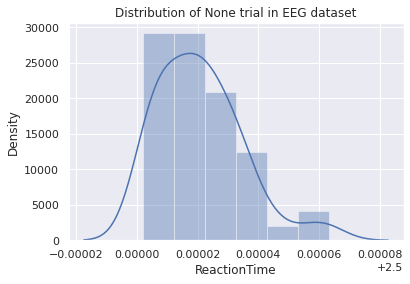

In [61]:
sns.distplot(eeg_[eeg_['Resp'] == 'None']['ReactionTime'])
pl.title('Distribution of None trial in EEG dataset');

In [62]:
checkset = eeg_.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
checkset[checkset['RespCorrect'] < 0.70]

,RespCorrect
Subject,


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 0.9929041114329372 Max 2.44919808 Min 0.39225969


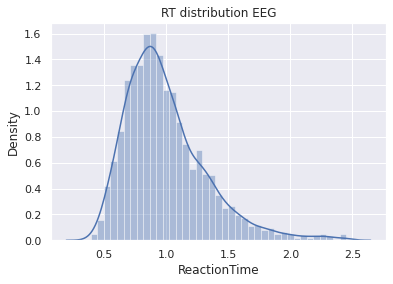

In [63]:
sns.distplot(eeg_[eeg_['Resp'] != 'None'].ReactionTime)
pl.title('RT distribution EEG');
print(
    'Mean', eeg_[eeg_['Resp'] != 'None'].ReactionTime.mean(),
    'Max', eeg_[eeg_['Resp'] != 'None'].ReactionTime.max(),
    'Min', eeg_[eeg_['Resp'] != 'None'].ReactionTime.min()
)

In [64]:
values = []
for i in eeg_[eeg_['Resp'] != 'None'].Subject.unique():
  subset = eeg_[eeg_['Resp'] != 'None']
  subset = subset[subset['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

E32 3
E34 2
E35 4
E36 8
E37 5
E38 3
E39 0
E40 5
E41 2
E42 1
E43 2
E44 1
E45 5
E46 0


In [65]:
len(values)

41

In [66]:
eeg_no_nones = eeg_[eeg_['Resp'] != 'None']

### Check for the correctness of labels

In [67]:
eeg_[eeg_['StimulusCategory'] == 'environment'].probeSound_name.unique()

array(['writing_on_paper', 'hair_dryer', 'typing', 'toothbrushing',
       'zipper', 'duck_quack', 'telephone_dialing', 'school_bell',
       'thunder', 'whistling', 'vacuum', 'biting_and_chewing', 'stream',
       'gargling', 'dog_panting', 'crickets', 'frog_croaking',
       'camera_snapping_photos', 'crowd_cheering', 'bees_buzzing',
       'cutting_with_scissors', 'frying', 'crow', 'door_knocking'],
      dtype=object)

In [68]:
eeg_[eeg_['StimulusCategory'] == 'nonwords'].probeSound_name.unique()

array(['zerlaht', 'tehsahf', 'thowster', 'prehjiy', 'tehlper', 'chuwpahl',
       'yehbahl', 'ferdahn', 'haasahp', 'nahlaht', 'jihnsiy', 'gowmaht',
       'wiykaan', 'viylahs', 'baeverd', 'puwgahl', 'drahjer', 'saechahn',
       'kaagaht', 'mahtern', 'shahnahl', 'hermahk', 'raedaht', 'gyuwtiy'],
      dtype=object)

In [69]:
eeg_[eeg_['StimulusCategory'] == 'words'].probeSound_name.unique()

array(['cushion', 'drama', 'vermin', 'member', 'quota', 'medic', 'vision',
       'cherub', 'chalice', 'chapter', 'menu', 'comic', 'rabbit',
       'porridge', 'topic', 'pleasure', 'duty', 'glacier', 'tunic',
       'bounty', 'rhythm', 'kitchen', 'madam', 'creature'], dtype=object)

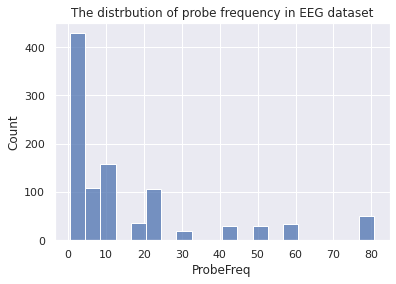

In [70]:
sns.histplot(eeg_.ProbeFreq)
pl.title('The distrbution of probe frequency in EEG dataset');

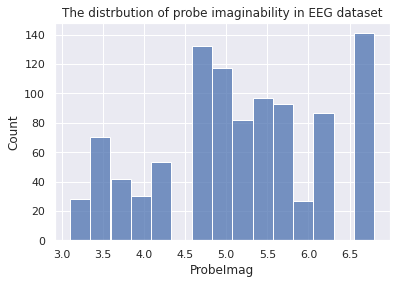

In [71]:
sns.histplot(eeg_.ProbeImag)
pl.title('The distrbution of probe imaginability in EEG dataset');

In [72]:
average = []
for i in eeg_.StimImag.values:
  if type(i) is list:
    average.append(sum(i)/len(i))

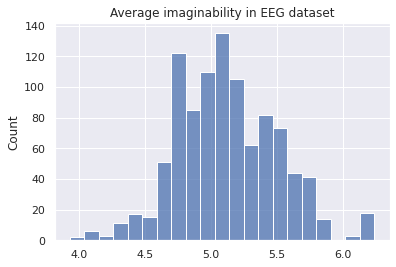

In [73]:
sns.histplot(average)
pl.title('Average imaginability in EEG dataset');

In [74]:
all_stim

,Category,Stimulus,Frequency,Imaginability
0,word,bounty,7.18,4.1
1,word,chalice,0.63,4.7
2,word,chapter,11.84,4.9
3,word,cherub,0.61,3.5
4,word,drama,20.16,4.9
5,word,duty,50.96,4.0
6,word,glacier,0.75,6.6
7,word,comic,10.82,5.4
8,word,kitchen,58.31,6.8
9,word,creature,21.41,6.0


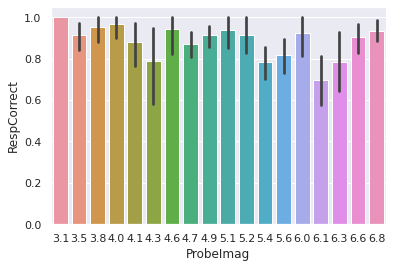

In [75]:
sns.barplot(x='ProbeImag', y='RespCorrect', data=eeg_[eeg_['StimulusCategory'] == 'words'])

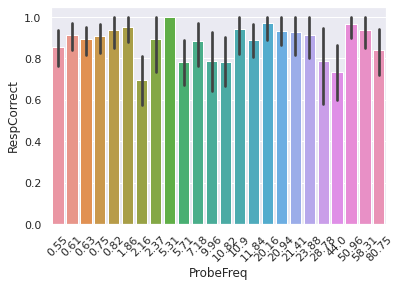

In [76]:
sns.barplot(x='ProbeFreq', y='RespCorrect', data=eeg_[eeg_['StimulusCategory'] == 'words'])
pl.xticks(rotation = 45); 

### Accuracy line plots

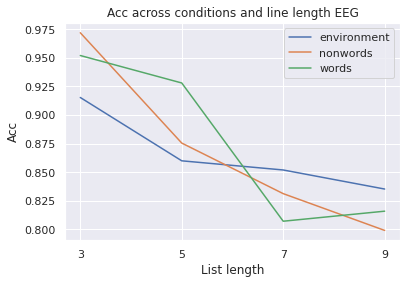

In [ ]:
pl.figure()
subset = eeg_.groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length EEG');

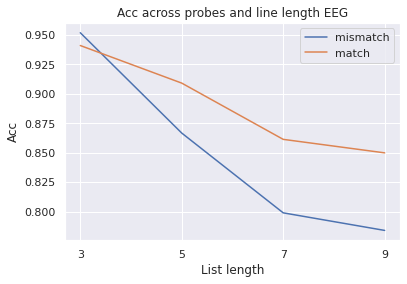

In [ ]:
pl.figure()
subset = eeg_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  if i == 1:
    name = 'match'
  elif i == 0:
    name = 'mismatch'    
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across probes and line length EEG');

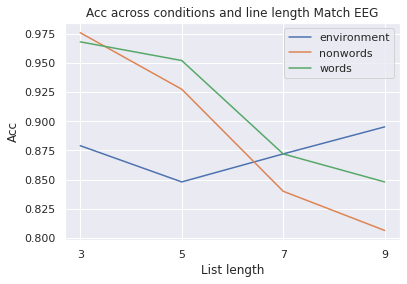

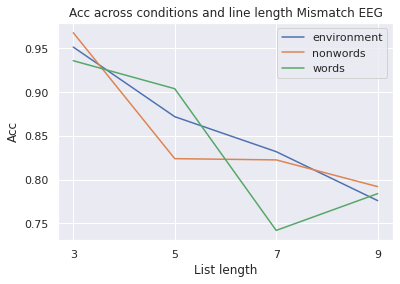

In [ ]:
# ONLY MATCH
pl.figure()
subset = eeg_[eeg_['ProbeCategory'] == 1].groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length Match EEG');

# ONLY MISMATCH
pl.figure()
subset = eeg_[eeg_['ProbeCategory'] == 0].groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length Mismatch EEG');

### Accuracy bar plots

Mismatch
Ttest_indResult(statistic=-0.4389020383028152, pvalue=0.6608277120027213)
Match
Ttest_indResult(statistic=1.1857806396954327, pvalue=0.2359951756431208)
Words
Ttest_indResult(statistic=-3.2880140531441757, pvalue=0.0010462918381034785)
Nonwords
Ttest_indResult(statistic=-1.6695554412802178, pvalue=0.09532619281509205)


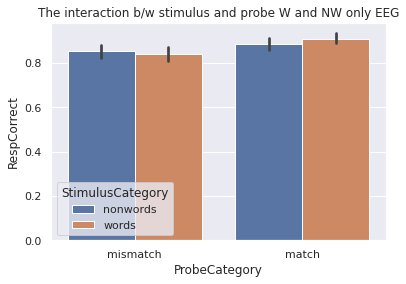

In [ ]:
# Probe type and Lex for W and NW only
ax=sns.barplot(x='ProbeCategory', y='RespCorrect', hue='StimulusCategory',
            data=eeg_[eeg_['StimulusCategory'] != 'environment'])
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The interaction b/w stimulus and probe W and NW only EEG')

print('Mismatch')
subset = eeg_[eeg_['StimulusCategory'] != 'environment']
sub = subset[subset['ProbeCategory'] == 0]
x, y = sub[sub['StimulusCategory'] == 'words']['RespCorrect'], sub[sub['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Match')
sub = subset[subset['ProbeCategory'] == 1]
x, y = sub[sub['StimulusCategory'] == 'words']['RespCorrect'], sub[sub['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Words')
sub = subset[subset['StimulusCategory'] == 'words']
x, y = sub[sub['ProbeCategory'] == 0]['RespCorrect'], sub[sub['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Nonwords')
sub = subset[subset['StimulusCategory'] == 'nonwords']
x, y = sub[sub['ProbeCategory'] == 0]['RespCorrect'], sub[sub['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

NW vs W
Ttest_indResult(statistic=-0.4284474906807684, pvalue=0.6683716818900234)
NW vs Environment
Ttest_indResult(statistic=0.2554350291355636, pvalue=0.798413506113592)
W vs Environment
Ttest_indResult(statistic=-0.6841461130546627, pvalue=0.4939625083085617)


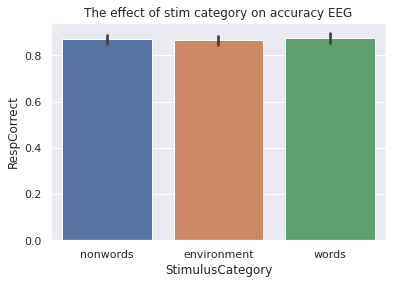

In [ ]:
# STIMULUS CATEGORY ON ACCURACY
sns.barplot(x='StimulusCategory', y='RespCorrect', data = eeg_)
pl.title('The effect of stim category on accuracy EEG');

print('NW vs W')
x, y = eeg_[eeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))
print('NW vs Environment')
x, y = eeg_[eeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('W vs Environment')
x, y = eeg_[eeg_['StimulusCategory'] == 'environment']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=-3.255935675875266, pvalue=0.0011430205875872846)


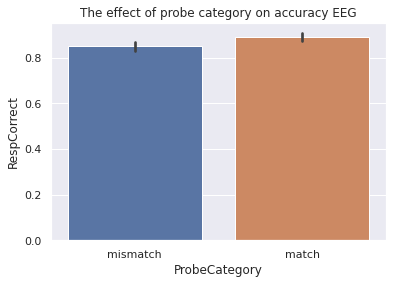

In [ ]:
# PROBE CATEGORY ON ACCURACY
ax = sns.barplot(x='ProbeCategory', y='RespCorrect', data = eeg_)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of probe category on accuracy EEG');

print('0 vs 1')
x, y = eeg_[eeg_['ProbeCategory'] == 0]['RespCorrect'], eeg_[eeg_['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

Length 3 vs 5
Ttest_indResult(statistic=4.132916286206337, pvalue=3.801901178090952e-05)
Length 5 vs 7
Ttest_indResult(statistic=-3.212870702346875, pvalue=0.0013430061875053276)
Length 7 vs 9
Ttest_indResult(statistic=0.6778518025150769, pvalue=0.4979706244516925)


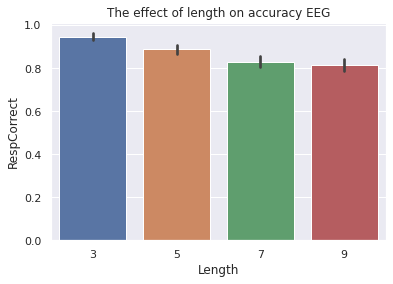

In [ ]:
# LENGTH ON ACCURACY
sns.barplot(x='Length', y='RespCorrect', data = eeg_)
pl.title('The effect of length on accuracy EEG');

print('Length 3 vs 5')
x, y = eeg_[eeg_['Length'] == 3]['RespCorrect'], eeg_[eeg_['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = eeg_[eeg_['Length'] == 7]['RespCorrect'], eeg_[eeg_['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = eeg_[eeg_['Length'] == 7]['RespCorrect'], eeg_[eeg_['Length'] == 9]['RespCorrect']
print(ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([-1.66955544]), pvalue=array([0.09532619]))
Environment
Ttest_indResult(statistic=array([-0.72983297]), pvalue=array([0.46566446]))
Words
Ttest_indResult(statistic=array([-3.28801405]), pvalue=array([0.00104629]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.43890204]), pvalue=array([0.66082771]))
W vs E Ttest_indResult(statistic=array([-0.70808498]), pvalue=array([0.47905815]))
NW vs E Ttest_indResult(statistic=array([0.26922055]), pvalue=array([0.78781573]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([1.18578064]), pvalue=array([0.23599518]))
W vs E Ttest_indResult(statistic=array([1.85698522]), pvalue=array([0.06361519]))
NW vs E Ttest_indResult(statistic=array([-0.67171276]), pvalue=array([0.50192317]))


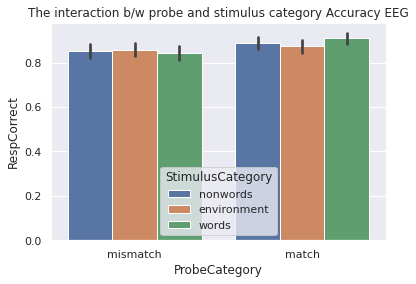

In [ ]:
# INTERACTION B/W PROBE AND STIMULUS
ax=sns.barplot(x='ProbeCategory', y='RespCorrect', hue='StimulusCategory', data = eeg_)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The interaction b/w probe and stimulus category Accuracy EEG');

print('0 vs 1')
print('Nonwords')
subset = eeg_[eeg_['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Environment')
subset = eeg_[eeg_['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = eeg_[eeg_['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = eeg_[eeg_['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

Mismatch
Length 3 vs 5
Ttest_indResult(statistic=4.100412106089179, pvalue=4.66403829548868e-05)
Length 5 vs 7
Ttest_indResult(statistic=-2.48878181853211, pvalue=0.013041343996750207)
Length 7 vs 9
Ttest_indResult(statistic=0.5018924462297406, pvalue=0.6158913363428782)
Match
Length 3 vs 5
Ttest_indResult(statistic=1.6581314334638786, pvalue=0.09772770721704117)
Length 5 vs 7
Ttest_indResult(statistic=-2.053408668773629, pvalue=0.04039183305675221)
Length 7 vs 9
Ttest_indResult(statistic=0.44557545574082075, pvalue=0.656033409136014)
Length 3
Ttest_indResult(statistic=0.6580283596730357, pvalue=0.5107251477603328)
Length 5
Ttest_indResult(statistic=-1.8418542391246469, pvalue=0.06590329240125425)
Length 7
Ttest_indResult(statistic=-2.27693263247104, pvalue=0.023079173340869768)
Length 9
Ttest_indResult(statistic=-2.3348712686890893, pvalue=0.01981935597590295)


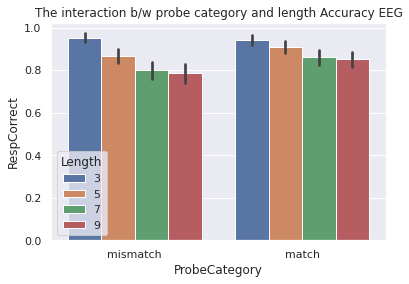

In [ ]:
# INTERACTION B/W PROBE CATEGORY AND LENGTH
ax = sns.barplot(x='ProbeCategory', y='RespCorrect', hue='Length', data = eeg_)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The interaction b/w probe category and length Accuracy EEG');

print('Mismatch')
subset = eeg_[eeg_['ProbeCategory'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))

print('Match')
subset = eeg_[eeg_['ProbeCategory'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))

print('Length 3')
subset = eeg_[eeg_['Length'] == 3]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Length 5')
subset = eeg_[eeg_['Length'] == 5]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Length 7')
subset = eeg_[eeg_['Length'] == 7]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Length 9')
subset = eeg_[eeg_['Length'] == 9]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

Nonwords
Length 3 vs 5
Ttest_indResult(statistic=4.111093346028933, pvalue=4.6082492734625756e-05)
Length 5 vs 7
Ttest_indResult(statistic=-1.3935616164249696, pvalue=0.16407412536743407)
Length 7 vs 9
Ttest_indResult(statistic=0.922669745544684, pvalue=0.3566279353453554)
Environment
Length 3 vs 5
Ttest_indResult(statistic=1.959222888897348, pvalue=0.050670880787850134)
Length 5 vs 7
Ttest_indResult(statistic=-0.2542639107512674, pvalue=0.7993966304176714)
Length 7 vs 9
Ttest_indResult(statistic=0.5114171711565207, pvalue=0.6092866133802122)
Words
Length 3 vs 5
Ttest_indResult(statistic=1.1290456267590538, pvalue=0.25942215645801125)
Length 5 vs 7
Ttest_indResult(statistic=-4.035132246561177, pvalue=6.46501375813529e-05)
Length 7 vs 9
Ttest_indResult(statistic=-0.2500468800879642, pvalue=0.8026544661688713)

Length 3
W vs NW
Ttest_indResult(statistic=-1.1604814274538935, pvalue=0.2464441488220609)
W vs E
Ttest_indResult(statistic=1.644690584763651, pvalue=0.1007120374752066)
E vs NW
T

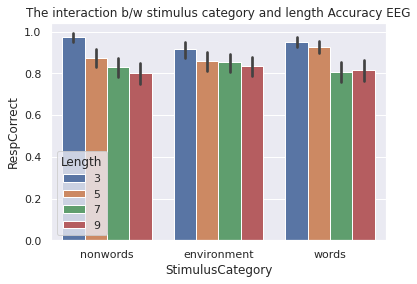

In [ ]:
# INTERACTION B/W STIMULUS CATEGORY AND LENGTH
sns.barplot(x='StimulusCategory', y='RespCorrect', hue='Length', data = eeg_)
pl.title('The interaction b/w stimulus category and length Accuracy EEG');

print('Nonwords')
subset = eeg_[eeg_['StimulusCategory'] == 'nonwords']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))
print('Environment')
subset = eeg_[eeg_['StimulusCategory'] == 'environment']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))

print('')
print('Length 3')
subset = eeg_[eeg_['Length'] == 3]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Length 5')
subset = eeg_[eeg_['Length'] == 5]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Length 7')
subset = eeg_[eeg_['Length'] == 7]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Length 9')
subset = eeg_[eeg_['Length'] == 9]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))

### Reaction Time line plots

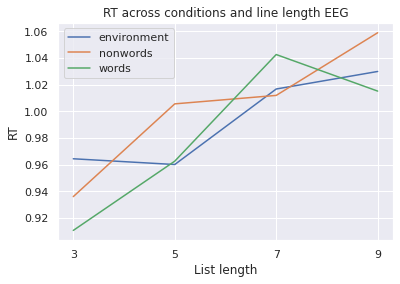

In [ ]:
pl.figure()
subset = eeg_no_nones.groupby(['StimulusCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.StimulusCategory.unique())
pl.title('RT across conditions and line length EEG');

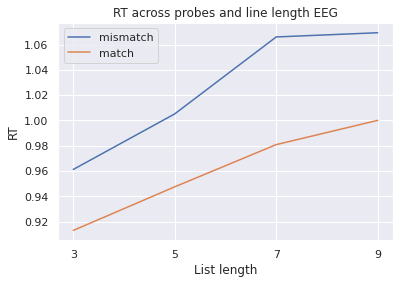

In [ ]:
pl.figure()
subset = eeg_no_nones.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  if i == 1:
    name = 'match'
  elif i == 0:
    name = 'mismatch'    
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('RT across probes and line length EEG');

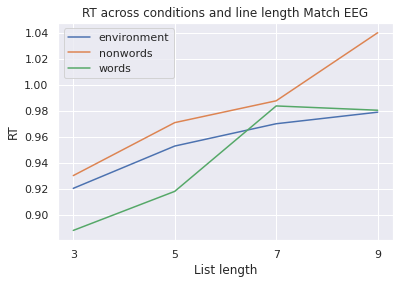

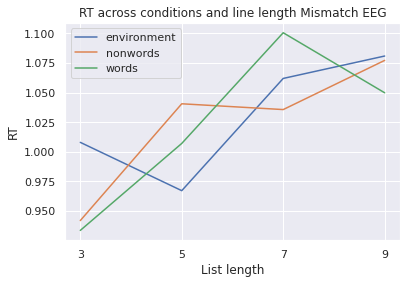

In [ ]:
# ONLY MATCH
pl.figure()
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1].groupby(['StimulusCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.StimulusCategory.unique())
pl.title('RT across conditions and line length Match EEG');

# ONLY MISMATCH
pl.figure()
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0].groupby(['StimulusCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.StimulusCategory.unique())
pl.title('RT across conditions and line length Mismatch EEG');

### Reaction Time bar plots 

NW vs W
Ttest_indResult(statistic=1.4175576266968544, pvalue=0.1564786424891116)
NW vs Environment
Ttest_indResult(statistic=0.6911049314570566, pvalue=0.48958161573610814)
W vs Environment
Ttest_indResult(statistic=0.70557677153618, pvalue=0.48053567710421374)


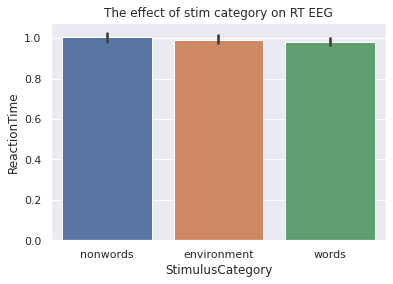

In [ ]:
# STIMULUS CATEGORY ON ACCURACY
sns.barplot(x='StimulusCategory', y='ReactionTime', data = eeg_no_nones)
pl.title('The effect of stim category on RT EEG');

print('NW vs W')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))
print('NW vs Environment')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('W vs Environment')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=5.467147264673293, pvalue=4.9621422878254886e-08)


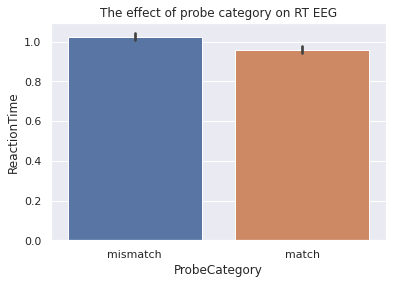

In [ ]:
# PROBE CATEGORY ON ACCURACY
ax = sns.barplot(x='ProbeCategory', y='ReactionTime', data = eeg_no_nones)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of probe category on RT EEG');

print('0 vs 1')
x, y = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0]['ReactionTime'], eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

Length 3 vs 5
Ttest_indResult(statistic=-2.387255243267083, pvalue=0.01710053469463928)
Length 5 vs 7
Ttest_indResult(statistic=2.8295807472835715, pvalue=0.004724521185736144)
Length 7 vs 9
Ttest_indResult(statistic=-0.6327728060558325, pvalue=0.5269803033072549)


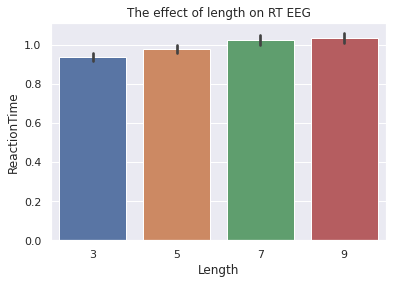

In [ ]:
# LENGTH ON ACCURACY
sns.barplot(x='Length', y='ReactionTime', data = eeg_no_nones)
pl.title('The effect of length on RT EEG');

print('Length 3 vs 5')
x, y = eeg_no_nones[eeg_no_nones['Length'] == 3]['ReactionTime'], eeg_no_nones[eeg_no_nones['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = eeg_no_nones[eeg_no_nones['Length'] == 7]['ReactionTime'], eeg_no_nones[eeg_no_nones['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = eeg_no_nones[eeg_no_nones['Length'] == 7]['ReactionTime'], eeg_no_nones[eeg_no_nones['Length'] == 9]['ReactionTime']
print(ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([1.97294624]), pvalue=array([0.04878211]))
Environment
Ttest_indResult(statistic=array([3.51478809]), pvalue=array([0.00046098]))
Words
Ttest_indResult(statistic=array([4.04411999]), pvalue=array([5.67472476e-05]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.0633929]), pvalue=array([0.94946653]))
W vs E Ttest_indResult(statistic=array([-0.31886219]), pvalue=array([0.74989931]))
NW vs E Ttest_indResult(statistic=array([0.25632907]), pvalue=array([0.79775083]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([-2.05449426]), pvalue=array([0.04019606]))
W vs E Ttest_indResult(statistic=array([-0.70738563]), pvalue=array([0.47949644]))
NW vs E Ttest_indResult(statistic=array([-1.33616723]), pvalue=array([0.18180731]))


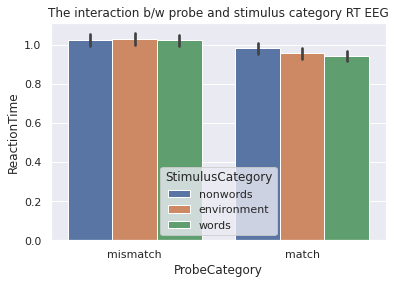

In [ ]:
# INTERACTION B/W PROBE AND STIMULUS
ax = sns.barplot(x='ProbeCategory', y='ReactionTime', hue='StimulusCategory', data = eeg_no_nones)
ax.set_xticklabels(['mismatch','match'])
pl.title('The interaction b/w probe and stimulus category RT EEG');

print('0 vs 1')
print('Nonwords')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Environment')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

Mismatch
Length 3 vs 5
Ttest_indResult(statistic=-1.784388889664443, pvalue=0.07477604681277272)
Length 5 vs 7
Ttest_indResult(statistic=2.4851480054219897, pvalue=0.013171895648954143)
Length 7 vs 9
Ttest_indResult(statistic=-0.1301242572843359, pvalue=0.8965036734532332)
Match
Length 3 vs 5
Ttest_indResult(statistic=-1.5999535580371238, pvalue=0.11004054851275095)
Length 5 vs 7
Ttest_indResult(statistic=1.4730238268258864, pvalue=0.1411757227959934)
Length 7 vs 9
Ttest_indResult(statistic=-0.8390638219290173, pvalue=0.40170719017302514)
Length 3
Ttest_indResult(statistic=2.0767232985018906, pvalue=0.03818738990008427)
Length 5
Ttest_indResult(statistic=2.5010385615165567, pvalue=0.012601513962726877)
Length 7
Ttest_indResult(statistic=3.5335807656025158, pvalue=0.0004358388686693889)
Length 9
Ttest_indResult(statistic=2.8393718336398286, pvalue=0.004647080468975698)


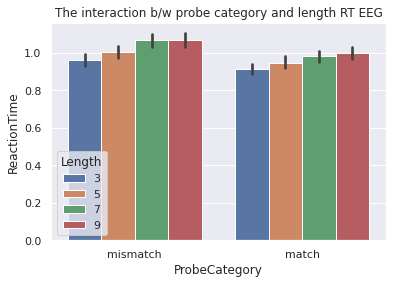

In [ ]:
# INTERACTION B/W PROBE CATEGORY AND LENGTH
ax = sns.barplot(x='ProbeCategory', y='ReactionTime', hue='Length', data = eeg_no_nones)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The interaction b/w probe category and length RT EEG');

print('Mismatch')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))

print('Match')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))

print('Length 3')
subset = eeg_no_nones[eeg_no_nones['Length'] == 3]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))
print('Length 5')
subset = eeg_no_nones[eeg_no_nones['Length'] == 5]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))
print('Length 7')
subset = eeg_no_nones[eeg_no_nones['Length'] == 7]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))
print('Length 9')
subset = eeg_no_nones[eeg_no_nones['Length'] == 9]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

Nonwords
Length 3 vs 5
Ttest_indResult(statistic=-2.3608850767808494, pvalue=0.01862312378878202)
Length 5 vs 7
Ttest_indResult(statistic=0.2203271375488629, pvalue=0.8257085756724849)
Length 7 vs 9
Ttest_indResult(statistic=-1.5672917499477528, pvalue=0.11768942054167505)
Environment
Length 3 vs 5
Ttest_indResult(statistic=0.14596794601139662, pvalue=0.8840075964258224)
Length 5 vs 7
Ttest_indResult(statistic=1.8632614555025342, pvalue=0.06303614489332564)
Length 7 vs 9
Ttest_indResult(statistic=-0.4349605168962148, pvalue=0.6637850866417293)
Words
Length 3 vs 5
Ttest_indResult(statistic=-1.9827935528199137, pvalue=0.04794672758821507)
Length 5 vs 7
Ttest_indResult(statistic=2.841668172035334, pvalue=0.004680985575271657)
Length 7 vs 9
Ttest_indResult(statistic=0.9260302241375165, pvalue=0.3548883194704572)

Length 3
W vs NW
Ttest_indResult(statistic=-0.906978738462696, pvalue=0.3648667134694521)
W vs E
Ttest_indResult(statistic=-1.901302048699282, pvalue=0.05785466106211742)
E vs NW


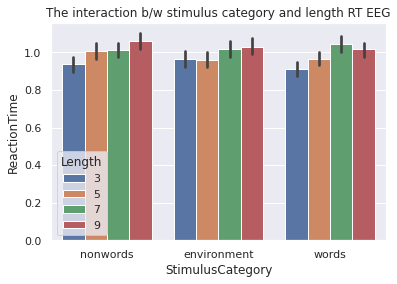

In [ ]:
# INTERACTION B/W STIMULUS CATEGORY AND LENGTH
sns.barplot(x='StimulusCategory', y='ReactionTime', hue='Length', data = eeg_no_nones)
pl.title('The interaction b/w stimulus category and length RT EEG');

print('Nonwords')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))
print('Environment')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))
print('Words')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))

print('')
print('Length 3')
subset = eeg_no_nones[eeg_no_nones['Length'] == 3]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('Length 5')
subset = eeg_no_nones[eeg_no_nones['Length'] == 5]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('Length 7')
subset = eeg_no_nones[eeg_no_nones['Length'] == 7]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('Length 9')
subset = eeg_no_nones[eeg_no_nones['Length'] == 9]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))

### Models

In [ ]:
eeg_.head()

**Accuracy**

In [ ]:
eeg_data = eeg_[['StimulusCategory', 'RespCorrect',
                 'ProbeCategory', 'ReactionTime',
                 'Trial', 'Subject', 'Length',
                 'Words', 'Nonwords', 'Environment']]

In [ ]:
%%R -i eeg_data
comp1<-lmer('RespCorrect ~ Length + ProbeCategory + (1|Subject)', data=eeg_data)
comp2<-lmer('RespCorrect ~ Length + ProbeCategory + Length:ProbeCategory + (1|Subject)', data=eeg_data)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    5 1892.214 1922.233 -941.1070 1882.214       NA NA         NA
2    6 1888.883 1924.905 -938.4415 1876.883 5.331088  1  0.0209483


In [ ]:
tryout1 = Lmer(
    'RespCorrect ~ Length + ProbeCategory + Length:ProbeCategory + (1|Subject)',
    data = eeg_data
)
tryout1.fit()

Formula: RespCorrect~Length+ProbeCategory+Length:ProbeCategory+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2992	 Groups: {'Subject': 14.0}

Log-likelihood: -955.070 	 AIC: 1910.140

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.024
Residual               0.109  0.331

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.021,0.972,1.071,0.025,726.061,40.400,0.000,***
Length,-0.029,-0.036,-0.021,0.004,2974.905,-7.470,0.000,***
ProbeCategory,-0.035,-0.103,0.033,0.035,2974.905,-1.012,0.312,
Length:ProbeCategory,0.012,0.002,0.023,0.005,2974.903,2.309,0.021,*


**Reaction time**

In [ ]:
eeg_rt_data = eeg_no_nones[['StimulusCategory', 'RespCorrect',
                 'ProbeCategory', 'ReactionTime',
                 'Trial', 'Subject', 'Length',
                 'Words', 'Nonwords', 'Environment']]

In [ ]:
%%R -i eeg_rt_data
comp1<-lmer('ReactionTime ~ ProbeCategory + Length + (1|Subject)', data=eeg_rt_data)
comp2<-lmer('ReactionTime ~ ProbeCategory + Length + ProbeCategory:Length + (1|Subject)', data=eeg_rt_data)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    5 163.4806 193.4199 -76.74031 153.4806       NA NA         NA
2    6 164.3557 200.2828 -76.17783 152.3557 1.124954  1  0.2888542


In [ ]:
tryout1 = Lmer(
    'ReactionTime ~ ProbeCategory + Length + (1|Subject)',
    data = eeg_rt_data
)
tryout1.fit()

Formula: ReactionTime~ProbeCategory+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2945	 Groups: {'Subject': 14.0}

Log-likelihood: -87.769 	 AIC: 175.538

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.046  0.214
Residual               0.060  0.246

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.928,0.813,1.044,0.059,14.359,15.769,0.0,***
ProbeCategory,-0.066,-0.084,-0.048,0.009,2929.004,-7.289,0.0,***
Length,0.017,0.013,0.021,0.002,2929.005,8.252,0.0,***


## iEEG

### Preprocessing

In [30]:
ieeg.shape

(3800, 28)

In [31]:
ieeg[~ieeg['ProbeType'].isnull()].Subject.unique()

array(['D27'], dtype=object)

In [77]:
ieeg[~ieeg['ProbeType'].isnull()].shape

(160, 28)

In [78]:
ieeg_preprocess = ieeg[ieeg['ProbeType'].isnull()]

In [79]:
ieeg_preprocess.shape

(3640, 28)

In [80]:
ieeg_preprocess.columns

Index(['Unnamed: 0', 'block', 'ProbeType', 'ProbeTypeName', 'StimlusCategory',
       'ReactionTime', 'KeyCode', 'Resp', 'RespCorrect', 'Omission',
       'stimulusAudioStart', 'stimulusAlignedTrigger', 'probeAudioStart',
       'probeAlignedTrigger', 'TriggerValue', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'kb_deltasecs', 'trialOrder_All', 'ListenCueOnset',
       'MaintenancePeriodOnset', 'ProbeCueOnset', 'StimulusCategory', 'Trial',
       'Subject'],
      dtype='object')

In [81]:
ieeg_ = ieeg_preprocess[[
    'block', 'StimlusCategory',
       'ReactionTime', 'Resp', 'RespCorrect',
       'stimulusSounds_idx', 'ProbeCategory', 'probeSound_idx',
       'StimulusCategory', 'Trial', 'stimulusSounds_name', 'probeSound_name',
       'Subject'
]]

For now all the columns contain lists within lists.

In [83]:
block = ieeg_.block.values
new_block = []
for i in block:
  new_block.append(i[10])

In [84]:
stim_cat = ieeg_.StimlusCategory.values
new_stim = []
for i in stim_cat:
  if pd.isna(i) is True:
    new_stim.append(i)
  elif 'environment' in i:
    new_stim.append('environment')
  elif 'nonwords' in i:
    new_stim.append('nonwords')
  elif 'words' in i:
    new_stim.append('words')
  else:
    new_stim.append(i)

In [85]:
stim_cat1 = ieeg_.StimulusCategory.values
new_stim1 = []
for i in stim_cat1:
  if pd.isna(i) is True:
    new_stim1.append(i)
  elif 'environment' in i:
    new_stim1.append('environment')
  elif 'nonwords' in i:
    new_stim1.append('nonwords')
  elif 'words' in i:
    new_stim1.append('words')
  else:
    new_stim1.append(i)

In [86]:
rt = ieeg_.ReactionTime.values
new_rt = []
for i in rt:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']])]]', '')
  new_rt.append(float(new_i))

In [87]:
acc = ieeg_.RespCorrect.values
new_acc = []
for i in acc:
  if '1' in i:
    new_acc.append(1)
  elif '0' in i:
    new_acc.append(0)

In [88]:
resp = ieeg_.Resp.values
new_resp = []
for i in resp:
  if 'None' in i:
    new_resp.append('None')
  elif 'Yes' in i:
    new_resp.append('Yes')
  elif 'No' in i:
    new_resp.append('No')

In [89]:
probe = ieeg_.ProbeCategory.values
new_probe = []
for i in probe:
  if '1' in i:
    new_probe.append(1)
  elif '0' in i:
    new_probe.append(0)

In [90]:
probe_idx = ieeg_.probeSound_idx.values
new_probe_idx = []
for i in probe_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_probe_idx.append(int(new_i))

In [91]:
stim_idx = ieeg_.stimulusSounds_idx.values
new_stim_idx = []
for i in stim_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_stim_idx.append(re.findall(r'\d+', new_i))

Uniting two columns for stimulus category

In [92]:
ieeg_['block'] = new_block
ieeg_['StimlusCategory'] = new_stim
ieeg_['StimulusCategory'] = new_stim1
ieeg_['ReactionTime'] = new_rt
ieeg_['RespCorrect'] = new_acc
ieeg_['Resp'] = new_resp
ieeg_['ProbeCategory'] = new_probe
ieeg_['probeSound_idx'] = new_probe_idx
ieeg_['stimulusSounds_idx'] = new_stim_idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [93]:
stim1 = ieeg_.StimlusCategory.values
stim2 = ieeg_.StimulusCategory.values

In [94]:
categories = []
for i in range(0, ieeg_.shape[0]):
  if pd.isna(stim1[i]) is True:
    if pd.isna(stim2[i]) is False:
      categories.append(stim2[i])
    else:
      print('Check')
  elif pd.isna(stim1[i]) is False:
    if pd.isna(stim2[i]) is True:
      categories.append(stim1[i])
    else:
      print('Check')  

In [95]:
ieeg_['StimulusCategory'] = categories

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
ieeg_ = ieeg_.loc[:, ieeg_.columns != 'StimlusCategory']

In [97]:
# checking what are the list lengths for stimuli
length = []
for i in ieeg_.stimulusSounds_idx.values:
  if len(i) not in length:
    length.append(len(i))
print(length)

[3, 7, 9, 5]


In [98]:
length = []
for i in ieeg_.stimulusSounds_idx.values:
  length.append(len(i))
ieeg_['Length'] = length

In [99]:
words = []
nonwords = []
environment = []
for i in ieeg_.StimulusCategory.values:
  if i == 'nonwords':
    words.append(0)
    nonwords.append(1)
    environment.append(0)
  elif i == 'words':
    words.append(1)
    nonwords.append(0)
    environment.append(0)
  elif i == 'environment':
    words.append(0)
    nonwords.append(0)
    environment.append(1)

In [100]:
ieeg_['Words'] = words
ieeg_['Nonwords'] = nonwords
ieeg_['Environment'] = environment

In [101]:
ieeg_.head()

,block,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,stimulusSounds_name,probeSound_name,Subject,Length,Words,Nonwords,Environment
160,1,0.990436,No,1,"[3, 7, 15]",0,14,nonwords,0,[[array([[(array(['camera_snapping_photos.wav'...,"[[array(['telephone_dialing.wav'], dtype='<U21...",D28,3,0,1,0
161,1,1.302180,Yes,1,"[16, 7, 14, 13, 9, 11, 6]",1,11,words,1,"[[array([[(array(['typing.wav'], dtype='<U10')...","[[array(['hair_dryer.wav'], dtype='<U14')]]",D28,7,1,0,0
162,1,1.432630,Yes,1,"[17, 15, 13, 5, 9, 10, 7, 6, 1]",1,7,environment,2,"[[array([[(array(['writing_on_paper.wav'], dty...","[[array(['cutting_with_scissors.wav'], dtype='...",D28,9,0,0,1
163,1,1.160734,Yes,1,"[17, 1, 13]",1,13,environment,3,"[[array([[(array(['writing_on_paper.wav'], dty...","[[array(['stream.wav'], dtype='<U10')]]",D28,3,0,0,1
164,1,0.845712,Yes,1,"[16, 7, 10, 15, 12, 3, 2]",1,3,environment,4,"[[array([[(array(['typing.wav'], dtype='<U10')...","[[array(['camera_snapping_photos.wav'], dtype=...",D28,7,0,0,1


In [102]:
symbols = [
    'array', '[', '(', "'", 'dtype=', ')', ']', '<U', 'object', ',', ' ', 'wav', '.',
    'Psychtoolbox_Scripts', 'C', ':', 'Environmental_Sternberg', 'stim', 'env', '-',
    'Jan', 'name', 'folder', 'date', 'bytes', 'O', '\\', 'uint', 'isdirnum'
    ]

probe_names = ieeg_.probeSound_name.values
new_probe_names = []
for name in probe_names:
  for symbol in symbols:
    if symbol in name:
      name = name.replace(symbol, '')
  for element in name:
    if element.isdigit() == True:
      name = name.replace(element, '')
  new_probe_names.append(name)

stimulus_names = ieeg_.stimulusSounds_name.values
new_stim_names = []
for name in stimulus_names:
  for symbol in symbols:
    if symbol in name:
      name = name.replace(symbol, '')
  for element in name:
    if element.isdigit() == True:
      name = name.replace(element, '')
  new_stim_names.append(name.split('\n'))

In [103]:
ieeg_['stimulusSounds_name'] = new_stim_names
ieeg_['probeSound_name'] = new_probe_names

iEEG dataset has 'None' responses in the column 'Resp'. Reaction times corresponding to these trial are identical and either 2500 ms or 4000 ms. This is our No response trials, that we will treat as incorrect in Accuracy analysis and will get rid of them for RT analysis.

In [104]:
ieeg_.groupby(['Subject'])['Trial'].count()

Subject
D28    120
D30    168
D31    168
D32    168
D35    168
D37    168
D38    160
D39    168
D41    168
D42    168
D47    168
D53    168
D54    168
D55    168
D57    168
D63    168
D64    168
D65    168
D69    168
D71    168
D73    168
D77    168
Name: Trial, dtype: int64

In [105]:
ieeg_ = ieeg_[ieeg_['Subject'] != 'D28']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


241

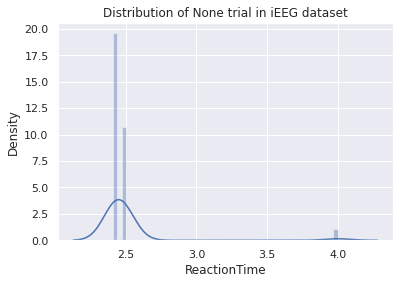

In [106]:
sns.distplot(ieeg_[ieeg_['Resp'] == 'None']['ReactionTime'])
pl.title('Distribution of None trial in iEEG dataset');
ieeg_[ieeg_['Resp'] == 'None']['ReactionTime'].count()

In [107]:
ieeg_[ieeg_['ReactionTime'] > 3.5].Subject.unique()

array(['D30', 'D31'], dtype=object)

In [108]:
print(
    ieeg_[(ieeg_['Subject'] == 'D30') & (ieeg_['ReactionTime'] > 2.4)].groupby(['StimulusCategory'])[['Trial']].count()
)
print(
    ieeg_[(ieeg_['Subject'] == 'D30') & (ieeg_['ReactionTime'] > 2.4)].groupby(['Length'])[['Trial']].count()
)


                  Trial
StimulusCategory       
environment           7
nonwords              4
words                 2
        Trial
Length       
3           5
5           2
7           1
9           5


In [109]:
print(
    ieeg_[(ieeg_['Subject'] == 'D31') & (ieeg_['ReactionTime'] > 2.4)].groupby(['StimulusCategory'])[['Trial']].count()
)
print(
    ieeg_[(ieeg_['Subject'] == 'D31') & (ieeg_['ReactionTime'] > 2.4)].groupby(['Length'])[['Trial']].count()
)

                  Trial
StimulusCategory       
environment           4
        Trial
Length       
3           2
5           1
7           1


In [110]:
idx1 = ieeg_[(ieeg_['Subject'] == 'D30') & (ieeg_['ReactionTime'] > 2.4)].index

In [111]:
idx2 = ieeg_[(ieeg_['Subject'] == 'D31') & (ieeg_['ReactionTime'] > 2.4)].index

In [112]:
ind = []
for i in idx1:
  ind.append(i)
for i in idx2:
  ind.append(i)

In [113]:
ieeg_ = ieeg_.drop(ind)

In [114]:
print(
    'Accuracy without "No response" trials',
    ieeg_[ieeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    ieeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8223241590214068
Accuracy with "No response" trials 0.7676277476448758


In [115]:
print('Shape of the dataset with no response trials', ieeg_.shape)
print('Shape of the dataset without no response trials', ieeg_[ieeg_['Resp'] != 'None'].shape)

Shape of the dataset with no response trials (3503, 16)
Shape of the dataset without no response trials (3270, 16)


In [116]:
checkset = ieeg_.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
checkset[checkset['RespCorrect'] < 0.70]

,RespCorrect
Subject,
D37,0.672619
D41,0.428571
D54,0.488095


In [117]:
ieeg_ = ieeg_[
    (ieeg_['Subject'] != 'D37') &
    (ieeg_['Subject'] != 'D41') &
    (ieeg_['Subject'] != 'D54')    
]

In [118]:
print(
    'Accuracy without "No response" trials',
    ieeg_[ieeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    ieeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8386426592797784
Accuracy with "No response" trials 0.8076025341780594


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 1.1775895428116343 Max 2.49319386 Min 0.2464664


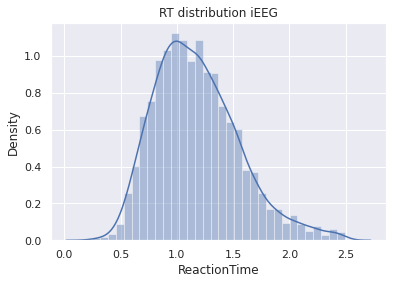

In [119]:
sns.distplot(ieeg_[ieeg_['Resp'] != 'None'].ReactionTime)
pl.title('RT distribution iEEG');
print(
    'Mean', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.mean(),
    'Max', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.max(),
    'Min', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.min()
)

In [120]:
values = []
for i in ieeg_[ieeg_['Resp'] != 'None'].Subject.unique():
  subset = ieeg_[ieeg_['Resp'] != 'None']
  subset = subset[subset['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

D30 1
D31 0
D32 0
D35 2
D38 7
D39 3
D42 0
D47 0
D53 1
D55 3
D57 0
D63 0
D69 1
D71 3
D64 0
D65 0
D73 2
D77 0


In [121]:
len(values)

23

### Check for the correctness of labels 

In [122]:
ieeg_[ieeg_['StimulusCategory'] == 'environment'].probeSound_name.unique()

array(['thunder', 'frog_croaking', 'bees_buzzing', 'hair_dryer',
       'camera_snapping_photos', 'writing_on_paper', 'school_bell',
       'biting_and_chewing', 'coin_in_vending_machine',
       'cutting_with_scissors', 'crickets', 'door_knocking',
       'telephone_dialing', 'dog_panting', 'stream', 'crow', 'typing',
       'zipper', 'frying', 'whistling', 'crowd_cheering', 'duck_quack',
       'vacuum', 'toothbrushing', 'gargling'], dtype=object)

In [123]:
ieeg_[ieeg_['StimulusCategory'] == 'nonwords'].probeSound_name.unique()

array(['bees_buzzing', 'typing', 'biting_and_chewing', 'hair_dryer',
       'camera_snapping_photos', 'cutting_with_scissors', 'thunder',
       'school_bell', 'stream', 'telephone_dialing', 'door_knocking',
       'writing_on_paper', 'dog_panting', 'crow', 'crickets',
       'frog_croaking', 'coin_in_vending_machine', 'yehbahl', 'haasahp',
       'zerlaht', 'puwgahl', 'gowmaht', 'shahnahl', 'hermahk', 'chuwpahl',
       'jihnsiy', 'kaagaht', 'ferdahn', 'mahtern', 'tehlper', 'tehsahf',
       'prehjiy', 'saechahn', 'raedaht', 'nahlaht', 'viylahs', 'baeverd',
       'drahjer', 'gyuwtiy', 'thowster', 'wiykaan'], dtype=object)

In [124]:
list_of_nonwords = ['bees_buzzing', 'typing', 'biting_and_chewing', 'hair_dryer',
       'camera_snapping_photos', 'cutting_with_scissors', 'thunder',
       'school_bell', 'stream', 'telephone_dialing', 'door_knocking',
       'writing_on_paper', 'dog_panting', 'crow', 'crickets',
       'frog_croaking', 'coin_in_vending_machine']
indices_nw = []
for i in list_of_nonwords:
  ind = ieeg_[(ieeg_['StimulusCategory'] == 'nonwords') & (ieeg_['probeSound_name'] == i)].index
  for each in ind:
    indices_nw.append(each)

In [125]:
ieeg_ = ieeg_.drop(indices_nw)

In [126]:
list_of_words = ['camera_snapping_photos', 'crickets', 'coin_in_vending_machine',
       'school_bell', 'biting_and_chewing', 'frog_croaking', 'typing',
       'dog_panting', 'crow', 'stream', 'hair_dryer', 'thunder',
       'cutting_with_scissors', 'bees_buzzing', 'telephone_dialing',
       'door_knocking', 'writing_on_paper']
indices_w = []
for i in list_of_words:
  ind = ieeg_[(ieeg_['StimulusCategory'] == 'words') & (ieeg_['probeSound_name'] == i)].index
  for each in ind:
    indices_w.append(each)

In [127]:
ieeg_ = ieeg_.drop(indices_w)

In [128]:
print(ieeg_[ieeg_['Subject'] == 'D30'].StimulusCategory.unique())
print(ieeg_[ieeg_['Subject'] == 'D31'].StimulusCategory.unique())

['environment']
['environment']


Only stimulus category left is environment. Let's drop these subjects.

In [130]:
ieeg_new = ieeg_[(ieeg_['Subject'] != 'D30') & (ieeg_['Subject'] != 'D31')]

### Adding frequency and imaginability

In [136]:
ieeg_new.groupby(['Subject'])[['RespCorrect']].mean()

,RespCorrect
Subject,
D32,0.779762
D35,0.833333
D38,0.800000
D39,0.755952
D42,0.875000
D47,0.791667
D53,0.851190
D55,0.839286
D57,0.880952


In [131]:
ieeg_new.head()

,block,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,stimulusSounds_name,probeSound_name,Subject,Length,Words,Nonwords,Environment
616,1,1.227901,No,1,"[68, 69, 64, 59, 54]",0,23,nonwords,0,"[thowster, viylahs, saechahn, mahtern, gyuwtiy]",yehbahl,D32,5,0,1,0
617,1,0.953294,Yes,0,"[10, 6, 4, 2, 16, 7, 22, 14, 15]",0,8,environment,1,"[duck_quack, crowd_cheering, crickets, biting_...",dog_panting,D32,9,0,0,1
618,1,1.314829,No,1,"[46, 36, 42, 34, 29]",0,2,words,2,"[tunic, madam, quota, glacier, comic]",chalice,D32,5,1,0,0
619,1,0.894159,Yes,1,"[36, 33, 28, 27, 46]",1,3,words,3,"[madam, duty, cherub, chapter, tunic]",chapter,D32,5,1,0,0
620,1,0.866337,No,0,"[71, 51, 55, 61, 59]",1,7,nonwords,4,"[yehbahl, drahjer, haasahp, prehjiy, mahtern]",haasahp,D32,5,0,1,0


In [137]:
category = ieeg_new.StimulusCategory.values.tolist()
probe = ieeg_new.probeSound_name.values
stimuli = ieeg_new.stimulusSounds_name.values
standard = all_stim[all_stim['Category'] == 'word']['Stimulus'].values.tolist()
standard_freq = all_stim[all_stim['Category'] == 'word']['Frequency'].values.tolist()
standard_imag = all_stim[all_stim['Category'] == 'word']['Imaginability'].values.tolist()

stim_freq = []
stim_imag = []
probe_freq = []
probe_imag = []

for i in range(0, len(category)):
  if category[i] == 'words':
    for name in standard:
      if probe[i] == name:
        freq = standard_freq[standard.index(name)]
        imag = standard_imag[standard.index(name)]
        probe_freq.append(freq)
        probe_imag.append(imag)

    values_freq = []
    values_imag = []      
    for lis in stimuli[i]:
      for name in standard:
        if lis == name:
          freq = standard_freq[standard.index(name)]
          imag = standard_imag[standard.index(name)]
          values_freq.append(freq)
          values_imag.append(imag)
    stim_freq.append(values_freq)
    stim_imag.append(values_imag)
  
  else:
    stim_freq.append(np.nan)
    stim_imag.append(np.nan)
    probe_freq.append(np.nan)
    probe_imag.append(np.nan)

In [138]:
print(ieeg_new.shape)
print(len(stim_freq))
print(len(stim_imag))
print(len(probe_freq))
print(len(probe_imag))

(2680, 16)
2680
2680
2680
2680


In [139]:
ieeg_new['ProbeFreq'] = probe_freq
ieeg_new['ProbeImag'] = probe_imag
ieeg_new['StimFreq'] = stim_freq
ieeg_new['StimImag'] = stim_imag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [140]:
ieeg_new.head()

,block,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,stimulusSounds_name,probeSound_name,Subject,Length,Words,Nonwords,Environment,ProbeFreq,ProbeImag,StimFreq,StimImag
616,1,1.227901,No,1,"[68, 69, 64, 59, 54]",0,23,nonwords,0,"[thowster, viylahs, saechahn, mahtern, gyuwtiy]",yehbahl,D32,5,0,1,0,NaN,NaN,NaN,NaN
617,1,0.953294,Yes,0,"[10, 6, 4, 2, 16, 7, 22, 14, 15]",0,8,environment,1,"[duck_quack, crowd_cheering, crickets, biting_...",dog_panting,D32,9,0,0,1,NaN,NaN,NaN,NaN
618,1,1.314829,No,1,"[46, 36, 42, 34, 29]",0,2,words,2,"[tunic, madam, quota, glacier, comic]",chalice,D32,5,1,0,0,0.63,4.7,"[0.55, 44.0, 1.86, 0.75, 10.82]","[5.6, 5.6, 3.8, 6.6, 5.4]"
619,1,0.894159,Yes,1,"[36, 33, 28, 27, 46]",1,3,words,3,"[madam, duty, cherub, chapter, tunic]",chapter,D32,5,1,0,0,11.84,4.9,"[44.0, 50.96, 0.61, 11.84, 0.55]","[5.6, 4.0, 3.5, 4.9, 5.6]"
620,1,0.866337,No,0,"[71, 51, 55, 61, 59]",1,7,nonwords,4,"[yehbahl, drahjer, haasahp, prehjiy, mahtern]",haasahp,D32,5,0,1,0,NaN,NaN,NaN,NaN


In [141]:
ieeg_no_nones = ieeg_new[ieeg_new['Resp'] != 'None']

In [142]:
print(ieeg_new.ProbeFreq.min())
print(ieeg_new.ProbeFreq.max())
print(ieeg_new.ProbeFreq.mean())

0.55
80.75
17.022060470324746


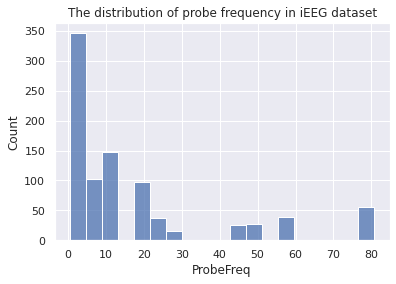

In [143]:
sns.histplot(ieeg_new.ProbeFreq)
pl.title('The distribution of probe frequency in iEEG dataset');

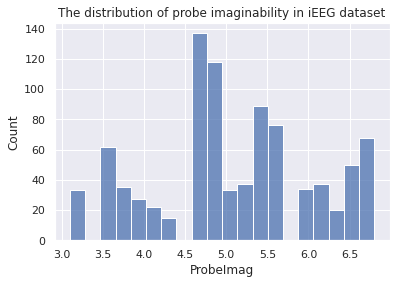

In [144]:
sns.histplot(ieeg_new.ProbeImag)
pl.title('The distribution of probe imaginability in iEEG dataset');

In [145]:
average = []
for i in ieeg_new.StimImag.values:
  if type(i) is list:
    average.append(sum(i)/len(i))

In [146]:
ieeg_new.StimFreq.values

array([nan, nan, list([0.55, 44.0, 1.86, 0.75, 10.82]), ..., nan,
       list([80.75, 7.18, 0.75, 5.71, 10.82, 23.88, 0.61]), nan],
      dtype=object)

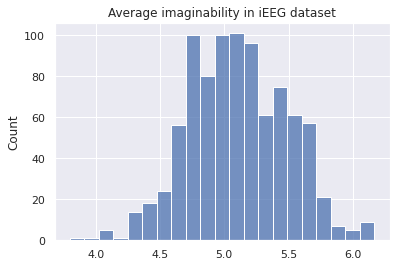

In [147]:
sns.histplot(average)
pl.title('Average imaginability in iEEG dataset');

In [152]:
ieeg_ = ieeg_new

### Accuracy line plots

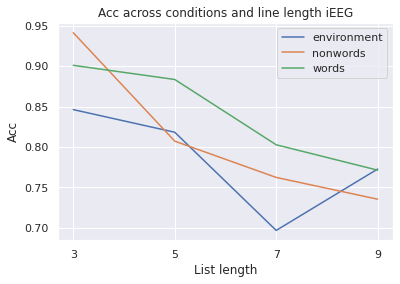

In [ ]:
pl.figure()
subset = ieeg_.groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length iEEG');

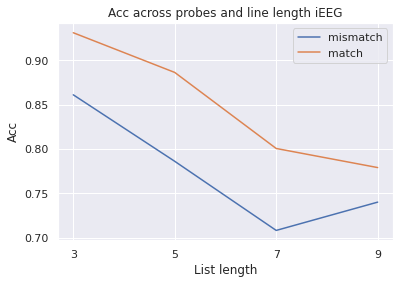

In [ ]:
pl.figure()
subset = ieeg_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  if i == 1:
    name = 'match'
  elif i == 0:
    name = 'mismatch'    
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across probes and line length iEEG');

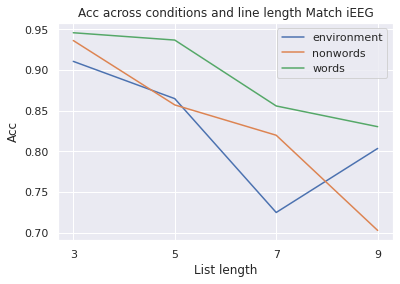

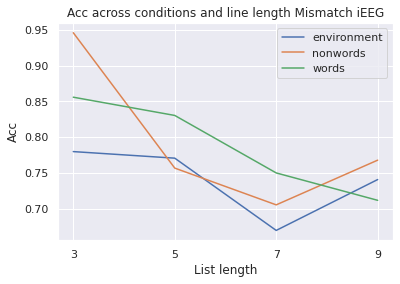

In [ ]:
# ONLY MATCH
pl.figure()
subset = ieeg_[ieeg_['ProbeCategory'] == 1].groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length Match iEEG');

# ONLY MISMATCH
pl.figure()
subset = ieeg_[ieeg_['ProbeCategory'] == 0].groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length Mismatch iEEG');

### Accuracy bar plots

Mismatch
Ttest_indResult(statistic=-0.9004237323335437, pvalue=0.3681378237247557)
Match
Ttest_indResult(statistic=2.8575294182643876, pvalue=0.00437221870176763)
Words
Ttest_indResult(statistic=-4.093970562156874, pvalue=4.648358056936293e-05)
Nonwords
Ttest_indResult(statistic=-0.33754313576449, pvalue=0.7357869144212095)


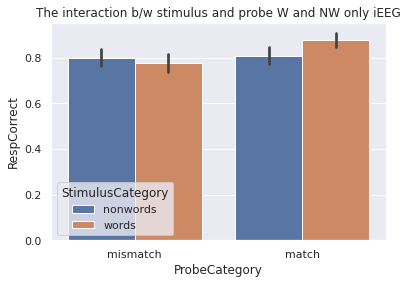

In [153]:
# Probe type and Lex for W and NW only
ax=sns.barplot(x='ProbeCategory', y='RespCorrect', hue='StimulusCategory',
            data=ieeg_[ieeg_['StimulusCategory'] != 'environment'])
ax.set_xticklabels(['mismatch','match'])
pl.title('The interaction b/w stimulus and probe W and NW only iEEG')

print('Mismatch')
subset = ieeg_[ieeg_['StimulusCategory'] != 'environment']
sub = subset[subset['ProbeCategory'] == 0]
x, y = sub[sub['StimulusCategory'] == 'words']['RespCorrect'], sub[sub['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Match')
sub = subset[subset['ProbeCategory'] == 1]
x, y = sub[sub['StimulusCategory'] == 'words']['RespCorrect'], sub[sub['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Words')
sub = subset[subset['StimulusCategory'] == 'words']
x, y = sub[sub['ProbeCategory'] == 0]['RespCorrect'], sub[sub['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Nonwords')
sub = subset[subset['StimulusCategory'] == 'nonwords']
x, y = sub[sub['ProbeCategory'] == 0]['RespCorrect'], sub[sub['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

NW vs W
Ttest_indResult(statistic=-1.5714398532755909, pvalue=0.11625909195287973)
NW vs Environment
Ttest_indResult(statistic=1.454901339081477, pvalue=0.14587453395918823)
W vs Environment
Ttest_indResult(statistic=-3.022688006014574, pvalue=0.0025419094389221132)


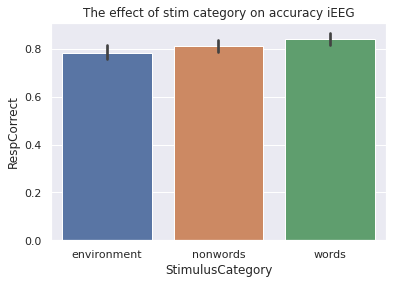

In [ ]:
# STIMULUS CATEGORY ON ACCURACY
sns.barplot(x='StimulusCategory', y='RespCorrect', data = ieeg_)
pl.title('The effect of stim category on accuracy iEEG');

print('NW vs W')
x, y = ieeg_[ieeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], ieeg_[ieeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))
print('NW vs Environment')
x, y = ieeg_[ieeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], ieeg_[ieeg_['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('W vs Environment')
x, y = ieeg_[ieeg_['StimulusCategory'] == 'environment']['RespCorrect'], ieeg_[ieeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=-5.003230800649704, pvalue=6.014369637596502e-07)


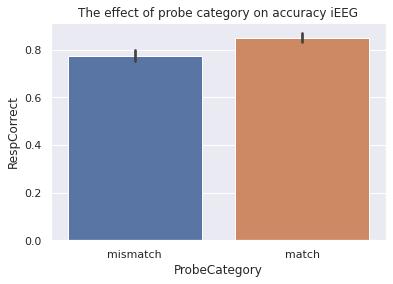

In [ ]:
# PROBE CATEGORY ON ACCURACY
ax = sns.barplot(x='ProbeCategory', y='RespCorrect', data = ieeg_)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of probe category on accuracy iEEG');

print('0 vs 1')
x, y = ieeg_[ieeg_['ProbeCategory'] == 0]['RespCorrect'], ieeg_[ieeg_['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

Length 3 vs 5
Ttest_indResult(statistic=3.21077519139395, pvalue=0.0013565992834228874)
Length 5 vs 7
Ttest_indResult(statistic=-3.736038384981854, pvalue=0.00019502991930840224)
Length 7 vs 9
Ttest_indResult(statistic=-0.23972712360960674, pvalue=0.8105787196551539)


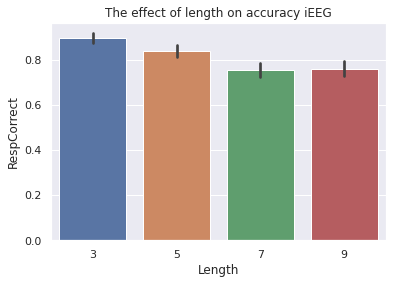

In [ ]:
# LENGTH ON ACCURACY
sns.barplot(x='Length', y='RespCorrect', data = ieeg_)
pl.title('The effect of length on accuracy iEEG');

print('Length 3 vs 5')
x, y = ieeg_[ieeg_['Length'] == 3]['RespCorrect'], ieeg_[ieeg_['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = ieeg_[ieeg_['Length'] == 7]['RespCorrect'], ieeg_[ieeg_['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = ieeg_[ieeg_['Length'] == 7]['RespCorrect'], ieeg_[ieeg_['Length'] == 9]['RespCorrect']
print(ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([-1.33826257]), pvalue=array([0.18115496]))
Environment
Ttest_indResult(statistic=array([-3.14181481]), pvalue=array([0.00173665]))
Words
Ttest_indResult(statistic=array([-4.31595509]), pvalue=array([1.78097358e-05]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.24649932]), pvalue=array([0.80535257]))
W vs E Ttest_indResult(statistic=array([1.65346673]), pvalue=array([0.09859447]))
NW vs E Ttest_indResult(statistic=array([-1.8989808]), pvalue=array([0.05789628]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([2.7318893]), pvalue=array([0.00642707]))
W vs E Ttest_indResult(statistic=array([2.82034541]), pvalue=array([0.00490845]))
NW vs E Ttest_indResult(statistic=array([-0.08876248]), pvalue=array([0.92929074]))


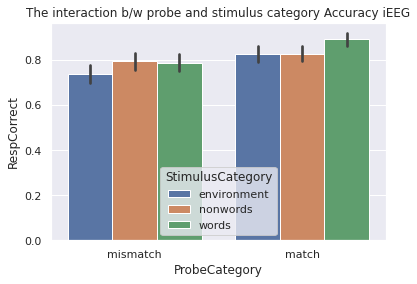

In [ ]:
# INTERACTION B/W PROBE AND STIMULUS
ax=sns.barplot(x='ProbeCategory', y='RespCorrect', hue='StimulusCategory', data = ieeg_)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The interaction b/w probe and stimulus category Accuracy iEEG');

print('0 vs 1')
print('Nonwords')
subset = ieeg_[ieeg_['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Environment')
subset = ieeg_[ieeg_['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = ieeg_[ieeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = ieeg_[ieeg_['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = ieeg_[ieeg_['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

Mismatch
Length 3 vs 5
Ttest_indResult(statistic=2.5379949571904774, pvalue=0.011383707545804278)
Length 5 vs 7
Ttest_indResult(statistic=-2.320267375351969, pvalue=0.02063018070643596)
Length 7 vs 9
Ttest_indResult(statistic=-0.9195720146266914, pvalue=0.35813003359376094)
Match
Length 3 vs 5
Ttest_indResult(statistic=2.0063153641891915, pvalue=0.04524633880072454)
Length 5 vs 7
Ttest_indResult(statistic=-3.0530408952025065, pvalue=0.0023610619478509165)
Length 7 vs 9
Ttest_indResult(statistic=0.680215136688261, pvalue=0.4966054961499864)
Length 3
Ttest_indResult(statistic=-2.963847604458449, pvalue=0.0031576809109017134)
Length 5
Ttest_indResult(statistic=-3.5150234888390446, pvalue=0.0004716094196289522)
Length 7
Ttest_indResult(statistic=-2.7814945875710384, pvalue=0.005566209463555815)
Length 9
Ttest_indResult(statistic=-1.1746268845807977, pvalue=0.24056701418091647)


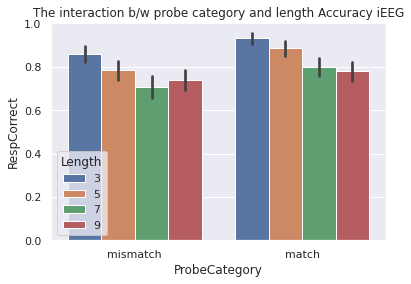

In [ ]:
# INTERACTION B/W PROBE CATEGORY AND LENGTH
ax = sns.barplot(x='ProbeCategory', y='RespCorrect', hue='Length', data = ieeg_)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The interaction b/w probe category and length Accuracy iEEG');

print('Mismatch')
subset = ieeg_[ieeg_['ProbeCategory'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))

print('Match')
subset = ieeg_[ieeg_['ProbeCategory'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))

print('Length 3')
subset = ieeg_[ieeg_['Length'] == 3]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Length 5')
subset = ieeg_[ieeg_['Length'] == 5]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Length 7')
subset = ieeg_[ieeg_['Length'] == 7]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))
print('Length 9')
subset = ieeg_[ieeg_['Length'] == 9]
x, y = subset[subset['ProbeCategory'] == 0]['RespCorrect'], subset[subset['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

Nonwords
Length 3 vs 5
Ttest_indResult(statistic=4.341309452126707, pvalue=1.8395826728461588e-05)
Length 5 vs 7
Ttest_indResult(statistic=-1.1512485111079882, pvalue=0.25024959061933777)
Length 7 vs 9
Ttest_indResult(statistic=0.6539876774563846, pvalue=0.5134583180724865)
Environment
Length 3 vs 5
Ttest_indResult(statistic=0.7846092394771096, pvalue=0.43310803071472614)
Length 5 vs 7
Ttest_indResult(statistic=-2.996935602488683, pvalue=0.002886222943969892)
Length 7 vs 9
Ttest_indResult(statistic=-1.8079515535658912, pvalue=0.0713035340734769)
Words
Length 3 vs 5
Ttest_indResult(statistic=0.5937688932636755, pvalue=0.5529711096443187)
Length 5 vs 7
Ttest_indResult(statistic=-2.352397591147147, pvalue=0.01908849624497085)
Length 7 vs 9
Ttest_indResult(statistic=0.8083389272080046, pvalue=0.4193283889158357)

Length 3
W vs NW
Ttest_indResult(statistic=-1.572944741591837, pvalue=0.116486685420346)
W vs E
Ttest_indResult(statistic=1.7349960157581026, pvalue=0.08346558523319386)
E vs NW
T

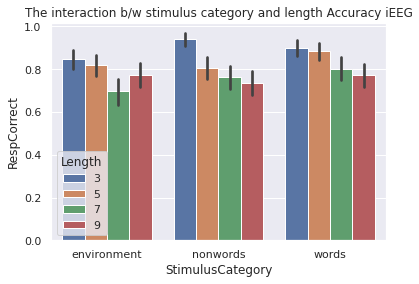

In [ ]:
# INTERACTION B/W STIMULUS CATEGORY AND LENGTH
sns.barplot(x='StimulusCategory', y='RespCorrect', hue='Length', data = ieeg_)
pl.title('The interaction b/w stimulus category and length Accuracy iEEG');

print('Nonwords')
subset = ieeg_[ieeg_['StimulusCategory'] == 'nonwords']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))
print('Environment')
subset = ieeg_[ieeg_['StimulusCategory'] == 'environment']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))
print('Words')
subset = ieeg_[ieeg_['StimulusCategory'] == 'words']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))

print('')
print('Length 3')
subset = ieeg_[ieeg_['Length'] == 3]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Length 5')
subset = ieeg_[ieeg_['Length'] == 5]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Length 7')
subset = ieeg_[ieeg_['Length'] == 7]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('Length 9')
subset = ieeg_[ieeg_['Length'] == 9]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))

### Reaction Time line plots

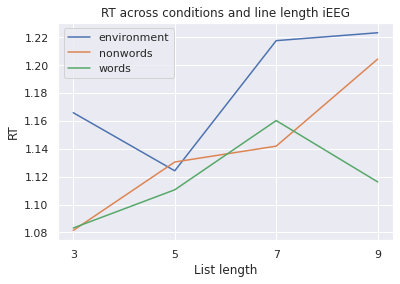

In [ ]:
pl.figure()
subset = ieeg_no_nones.groupby(['StimulusCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.StimulusCategory.unique())
pl.title('RT across conditions and line length iEEG');

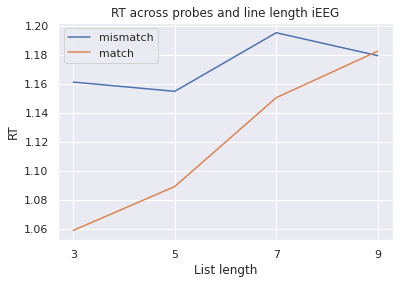

In [ ]:
pl.figure()
subset = ieeg_no_nones.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  if i == 1:
    name = 'match'
  elif i == 0:
    name = 'mismatch'    
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('RT across probes and line length iEEG');

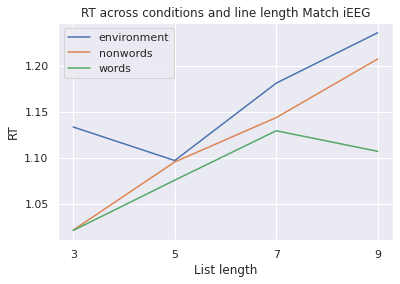

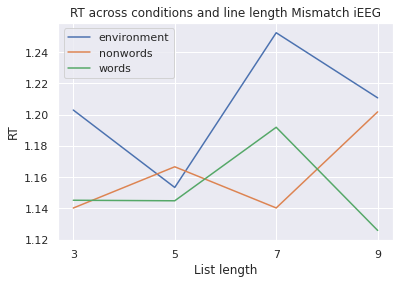

In [ ]:
# ONLY MATCH
pl.figure()
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1].groupby(['StimulusCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.StimulusCategory.unique())
pl.title('RT across conditions and line length Match iEEG');

# ONLY MISMATCH
pl.figure()
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0].groupby(['StimulusCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.StimulusCategory.unique())
pl.title('RT across conditions and line length Mismatch iEEG');

### Reaction Time bar plots

NW vs W
Ttest_indResult(statistic=1.262891485892922, pvalue=0.2067983814169355)
NW vs Environment
Ttest_indResult(statistic=-2.4172913021772855, pvalue=0.015741537147999696)
W vs Environment
Ttest_indResult(statistic=3.6887155465402737, pvalue=0.0002325430883851496)


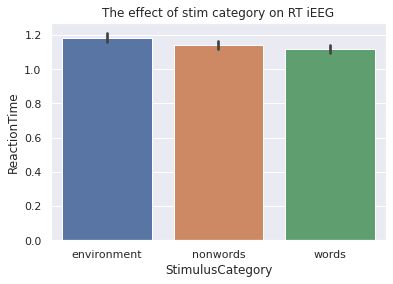

In [ ]:
# STIMULUS CATEGORY ON ACCURACY
sns.barplot(x='StimulusCategory', y='ReactionTime', data = ieeg_no_nones)
pl.title('The effect of stim category on RT iEEG');

print('NW vs W')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))
print('NW vs Environment')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('W vs Environment')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=3.6134038155183315, pvalue=0.00030799750033640264)


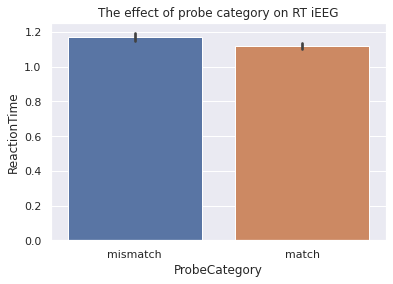

In [ ]:
# PROBE CATEGORY ON ACCURACY
ax = sns.barplot(x='ProbeCategory', y='ReactionTime', data = ieeg_no_nones)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of probe category on RT iEEG');

print('0 vs 1')
x, y = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0]['ReactionTime'], ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

Length 3 vs 5
Ttest_indResult(statistic=-0.6099562394130447, pvalue=0.5419999620046856)
Length 5 vs 7
Ttest_indResult(statistic=2.5681901468130106, pvalue=0.010335111522650915)
Length 7 vs 9
Ttest_indResult(statistic=-0.39478560395065965, pvalue=0.6930660188087467)


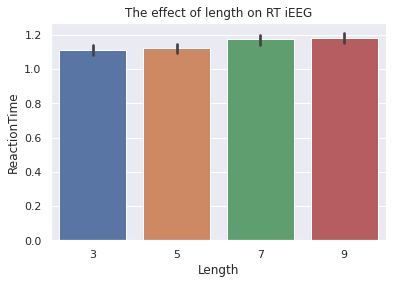

In [ ]:
# LENGTH ON ACCURACY
sns.barplot(x='Length', y='ReactionTime', data = ieeg_no_nones)
pl.title('The effect of length on RT iEEG');

print('Length 3 vs 5')
x, y = ieeg_no_nones[ieeg_no_nones['Length'] == 3]['ReactionTime'], ieeg_no_nones[ieeg_no_nones['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = ieeg_no_nones[ieeg_no_nones['Length'] == 7]['ReactionTime'], ieeg_no_nones[ieeg_no_nones['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = ieeg_no_nones[ieeg_no_nones['Length'] == 7]['ReactionTime'], ieeg_no_nones[ieeg_no_nones['Length'] == 9]['ReactionTime']
print(ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([1.82397111]), pvalue=array([0.06850353]))
Environment
Ttest_indResult(statistic=array([1.66858555]), pvalue=array([0.0955735]))
Words
Ttest_indResult(statistic=array([2.87344876]), pvalue=array([0.00415904]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.41512434]), pvalue=array([0.67815456]))
W vs E Ttest_indResult(statistic=array([-2.12561688]), pvalue=array([0.03383083]))
NW vs E Ttest_indResult(statistic=array([1.67088667]), pvalue=array([0.09511812]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([-1.38319459]), pvalue=array([0.16696086]))
W vs E Ttest_indResult(statistic=array([-3.13668998]), pvalue=array([0.0017672]))
NW vs E Ttest_indResult(statistic=array([1.78444253]), pvalue=array([0.07470642]))


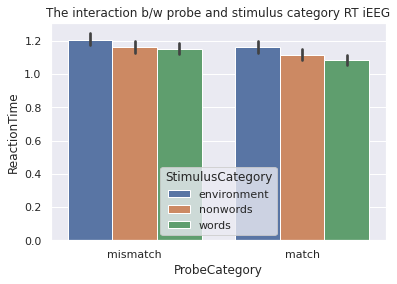

In [ ]:
# INTERACTION B/W PROBE AND STIMULUS
ax=sns.barplot(x='ProbeCategory', y='ReactionTime', hue='StimulusCategory', data = ieeg_no_nones)
ax.set_xticklabels(['mismatch','match'])
pl.title('The interaction b/w probe and stimulus category RT iEEG');

print('0 vs 1')
print('Nonwords')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Environment')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

Mismatch
Length 3 vs 5
Ttest_indResult(statistic=0.21296188625929907, pvalue=0.8314265159089169)
Length 5 vs 7
Ttest_indResult(statistic=1.4239592228984856, pvalue=0.15494722602537347)
Length 7 vs 9
Ttest_indResult(statistic=0.5463355984699786, pvalue=0.5850243674989597)
Match
Length 3 vs 5
Ttest_indResult(statistic=-1.1076473583619146, pvalue=0.26842704763548536)
Length 5 vs 7
Ttest_indResult(statistic=2.188975420659125, pvalue=0.028955806750511643)
Length 7 vs 9
Ttest_indResult(statistic=-1.0944815449675556, pvalue=0.2741490577437703)
Length 3
Ttest_indResult(statistic=3.490761487677921, pvalue=0.000515820353146881)
Length 5
Ttest_indResult(statistic=2.343747433182841, pvalue=0.019398425346283516)
Length 7
Ttest_indResult(statistic=1.5800194163271064, pvalue=0.11459150671894708)
Length 9
Ttest_indResult(statistic=-0.10298194835767019, pvalue=0.9180090125055533)


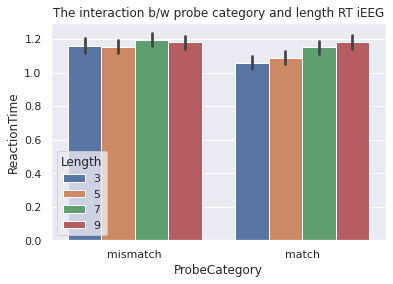

In [ ]:
# INTERACTION B/W PROBE CATEGORY AND LENGTH
ax = sns.barplot(x='ProbeCategory', y='ReactionTime', hue='Length', data = ieeg_no_nones)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The interaction b/w probe category and length RT iEEG');

print('Mismatch')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))

print('Match')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))

print('Length 3')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 3]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))
print('Length 5')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 5]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))
print('Length 7')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 7]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))
print('Length 9')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 9]
x, y = subset[subset['ProbeCategory'] == 0]['ReactionTime'], subset[subset['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

Nonwords
Length 3 vs 5
Ttest_indResult(statistic=-1.4133604655249326, pvalue=0.1582751442881335)
Length 5 vs 7
Ttest_indResult(statistic=0.3413104047486954, pvalue=0.7330384771796843)
Length 7 vs 9
Ttest_indResult(statistic=-1.7702983767004428, pvalue=0.07741209256567835)
Environment
Length 3 vs 5
Ttest_indResult(statistic=1.1642868050723123, pvalue=0.24500935452910821)
Length 5 vs 7
Ttest_indResult(statistic=2.603756122076701, pvalue=0.009560315730438277)
Length 7 vs 9
Ttest_indResult(statistic=-0.14679869923950548, pvalue=0.8833602868129551)
Words
Length 3 vs 5
Ttest_indResult(statistic=-0.7830877065598132, pvalue=0.4340069334295884)
Length 5 vs 7
Ttest_indResult(statistic=1.4518343578141568, pvalue=0.14727191871041956)
Length 7 vs 9
Ttest_indResult(statistic=1.3649568781540076, pvalue=0.17296732494265513)

Length 3
W vs NW
Ttest_indResult(statistic=0.05094145876072807, pvalue=0.9593959344090295)
W vs E
Ttest_indResult(statistic=-2.2504437228453202, pvalue=0.024952368532290284)
E vs 

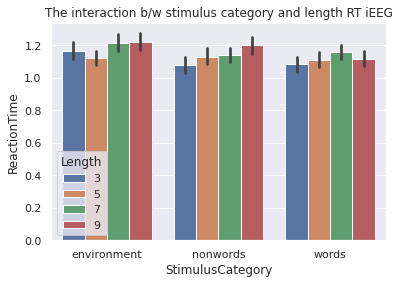

In [ ]:
# INTERACTION B/W STIMULUS CATEGORY AND LENGTH
sns.barplot(x='StimulusCategory', y='ReactionTime', hue='Length', data = ieeg_no_nones)
pl.title('The interaction b/w stimulus category and length RT iEEG');

print('Nonwords')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))
print('Environment')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))
print('Words')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 5]['ReactionTime']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['ReactionTime'], subset[subset['Length'] == 9]['ReactionTime']
print(ttest(x,y))

print('')
print('Length 3')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 3]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('Length 5')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 5]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('Length 7')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 7]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('Length 9')
subset = ieeg_no_nones[ieeg_no_nones['Length'] == 9]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['ReactionTime'], subset[subset['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['ReactionTime'], subset[subset['StimulusCategory'] == 'nonwords']['ReactionTime']
print(ttest(x,y))

### Models

**Accuracy**

In [154]:
ieeg_data = ieeg_[[
    'StimulusCategory', 'RespCorrect', 'ReactionTime',
    'ProbeCategory', 'Trial', 'Subject', 'Length',
    'Words', 'Nonwords', 'Environment'
]]

In [155]:
%%R -i ieeg_data
comp1<-lmer('RespCorrect ~ ProbeCategory + Length + StimulusCategory + (1|Subject)', data=ieeg_data)
comp2<-lmer('RespCorrect ~ ProbeCategory + Length + StimulusCategory + Length:StimulusCategory + (1|Subject)', data=ieeg_data)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    7 2593.248 2634.503 -1289.624 2579.248       NA NA         NA
2    9 2590.710 2643.753 -1286.355 2572.710 6.537594  2 0.03805217


In [156]:
tryout1 = Lmer(
    'RespCorrect ~ ProbeCategory + Length + StimulusCategory + (1|Subject)',
    data = ieeg_data
)
tryout1.fit()

Formula: RespCorrect~ProbeCategory+Length+StimulusCategory+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2680	 Groups: {'Subject': 16.0}

Log-likelihood: -1307.544 	 AIC: 2615.088

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.033
Residual               0.153  0.391

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.875,0.823,0.927,0.027,422.128,32.908,0.000,***
ProbeCategory,0.058,0.029,0.088,0.015,2660.040,3.852,0.000,***
Length,-0.020,-0.027,-0.014,0.003,2660.040,-6.007,0.000,***
StimulusCategorynonwords,0.023,-0.014,0.059,0.018,2660.048,1.228,0.219,
StimulusCategorywords,0.045,0.009,0.081,0.019,2660.040,2.432,0.015,*


In [ ]:
%%R -i ieeg_data
comp1<-lmer('RespCorrect ~ ProbeCategory + Length + Words + Environment + (1|Subject)', data=ieeg_data)
comp2<-lmer('RespCorrect ~ ProbeCategory + Length + Words + Environment + Nonwords + (1|Subject)', data=ieeg_data)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance Chisq Df Pr..Chisq.
1    7 2478.151 2519.362 -1232.076 2464.151    NA NA         NA
2    7 2478.151 2519.362 -1232.076 2464.151     0  0         NA


**Reaction time**

In [ ]:
ieeg_rt_data = ieeg_no_nones[[
    'StimulusCategory', 'RespCorrect', 'ReactionTime',
    'ProbeCategory', 'Trial', 'Subject', 'Length',
    'Words', 'Nonwords', 'Environment'
]]

In [ ]:
%%R -i ieeg_rt_data
comp1<-lmer('ReactionTime ~ StimulusCategory + ProbeCategory + Length + ProbeCategory:Length + (1|Subject)', data=ieeg_rt_data)
comp2<-lmer('ReactionTime ~ StimulusCategory + ProbeCategory + Length + ProbeCategory:Length + StimulusCategory:ProbeCategory + (1|Subject)', data=ieeg_rt_data)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    8 974.5085 1021.344 -479.2542 958.5085       NA NA         NA
2   10 977.3618 1035.906 -478.6809 957.3618 1.146717  2  0.5636294


In [ ]:
tryout1 = Lmer(
    'ReactionTime ~ StimulusCategory + ProbeCategory + Length + ProbeCategory:Length + (1|Subject)',
    data = ieeg_rt_data
)
tryout1.fit()

Formula: ReactionTime~StimulusCategory+ProbeCategory+Length+ProbeCategory:Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2577	 Groups: {'Subject': 16.0}

Log-likelihood: -501.044 	 AIC: 1002.088

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.054  0.232
Residual               0.083  0.288

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.187,1.064,1.310,0.063,20.561,18.853,0.000,***
StimulusCategorynonwords,-0.046,-0.073,-0.019,0.014,2556.014,-3.311,0.001,***
StimulusCategorywords,-0.067,-0.095,-0.040,0.014,2556.027,-4.852,0.000,***
ProbeCategory,-0.160,-0.224,-0.096,0.033,2556.019,-4.918,0.000,***
Length,0.005,-0.002,0.012,0.004,2556.013,1.321,0.186,
ProbeCategory:Length,0.017,0.008,0.027,0.005,2556.016,3.443,0.001,***


### Imaginability and frequency

In [158]:
ieeg_words = ieeg_[ieeg_['StimulusCategory'] == 'words']

Let's look into the probes first.

80.75
0.55


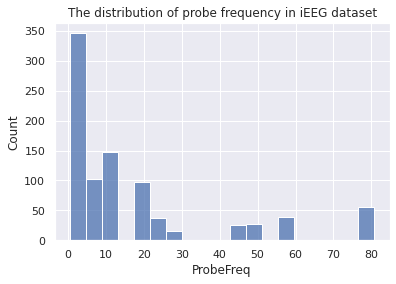

In [161]:
sns.histplot(ieeg_words.ProbeFreq)
pl.title('The distribution of probe frequency in iEEG dataset');
print(ieeg_words.ProbeFreq.max())
print(ieeg_words.ProbeFreq.min())

Text(0.5, 1.0, 'Correlation Heatmap')

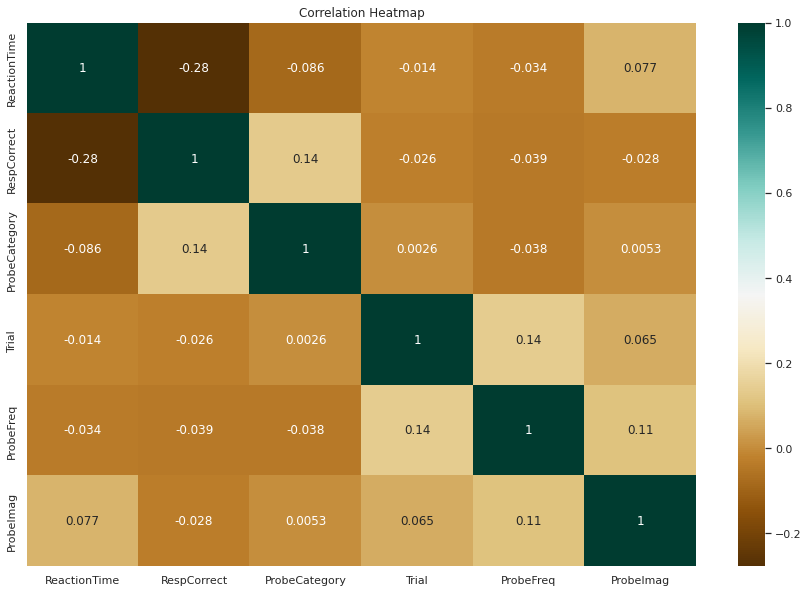

In [165]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(
    ieeg_words[['ReactionTime', 'RespCorrect', 'ProbeCategory', 'Trial', 'ProbeFreq', 'ProbeImag']].corr(method='pearson'), 
    annot = True, cmap="BrBG"
    )
plt.title("Correlation Heatmap")

6.8
3.1


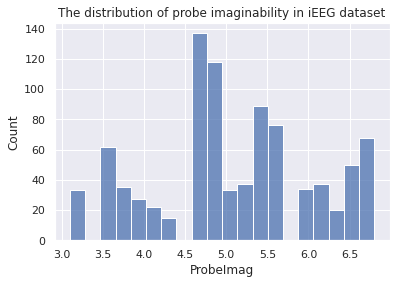

In [167]:
sns.histplot(ieeg_words.ProbeImag)
pl.title('The distribution of probe imaginability in iEEG dataset');
print(ieeg_words.ProbeImag.max())
print(ieeg_words.ProbeImag.min())

In [221]:
freq_cat = []
probe_freq = ieeg_words.ProbeFreq.values
for i in probe_freq:
  if i < 25:
    freq_cat.append('low')
  elif 25 <= i <= 50:
    freq_cat.append('middle')
  elif i > 50:
    freq_cat.append('high')
print(len(probe_freq))
print(len(freq_cat))

893
893


In [222]:
imag_cat = []
probe_imag = ieeg_words.ProbeImag.values
for i in probe_imag:
  if i < 4.3:
    imag_cat.append('low')
  elif 4.3 <= i <= 5.5:
    imag_cat.append('middle')
  elif i > 5.5:
    imag_cat.append('high')
print(len(probe_imag))
print(len(imag_cat))

893
893


In [223]:
ieeg_words['FreqCat'] = freq_cat
ieeg_words['ImagCat'] = imag_cat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Ttest_indResult(statistic=0.27825877131490634, pvalue=0.7809829138528976)
Ttest_indResult(statistic=1.0179712060287223, pvalue=0.3093051678595217)
Ttest_indResult(statistic=-0.9311310025737777, pvalue=0.352171417810899)


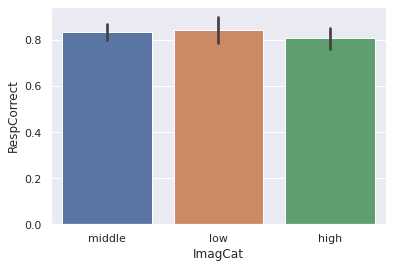

In [225]:
sns.barplot(x='ImagCat', y='RespCorrect', data = ieeg_words);

x, y = ieeg_words[ieeg_words['ImagCat'] == 'low']['RespCorrect'], ieeg_words[ieeg_words['ImagCat'] == 'middle']['RespCorrect']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['ImagCat'] == 'low']['RespCorrect'], ieeg_words[ieeg_words['ImagCat'] == 'high']['RespCorrect']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['ImagCat'] == 'high']['RespCorrect'], ieeg_words[ieeg_words['ImagCat'] == 'middle']['RespCorrect']
print(ttest(x,y))

Ttest_indResult(statistic=-0.11122755894000459, pvalue=0.9114987753897814)
Ttest_indResult(statistic=-2.2373979872310357, pvalue=0.02577211815878548)
Ttest_indResult(statistic=2.5063091700214017, pvalue=0.012485412518962477)


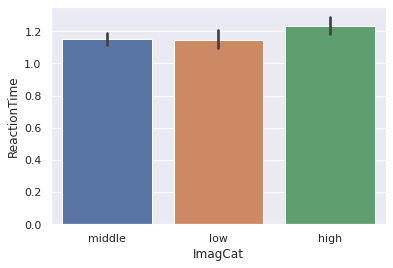

In [226]:
sns.barplot(x='ImagCat', y='ReactionTime', data = ieeg_words);

x, y = ieeg_words[ieeg_words['ImagCat'] == 'low']['ReactionTime'], ieeg_words[ieeg_words['ImagCat'] == 'middle']['ReactionTime']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['ImagCat'] == 'low']['ReactionTime'], ieeg_words[ieeg_words['ImagCat'] == 'high']['ReactionTime']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['ImagCat'] == 'high']['ReactionTime'], ieeg_words[ieeg_words['ImagCat'] == 'middle']['ReactionTime']
print(ttest(x,y))

Ttest_indResult(statistic=1.1910156496797506, pvalue=0.24013876151868283)
Ttest_indResult(statistic=1.3399805436699403, pvalue=0.18223440328989782)
Ttest_indResult(statistic=0.3742237945505739, pvalue=0.7094362323435719)


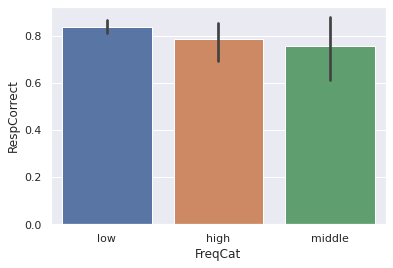

In [227]:
sns.barplot(x='FreqCat', y='RespCorrect', data = ieeg_words);

x, y = ieeg_words[ieeg_words['FreqCat'] == 'low']['RespCorrect'], ieeg_words[ieeg_words['FreqCat'] == 'middle']['RespCorrect']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['FreqCat'] == 'low']['RespCorrect'], ieeg_words[ieeg_words['FreqCat'] == 'high']['RespCorrect']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['FreqCat'] == 'high']['RespCorrect'], ieeg_words[ieeg_words['FreqCat'] == 'middle']['RespCorrect']
print(ttest(x,y))

Ttest_indResult(statistic=-0.7813494788462693, pvalue=0.43878274394529204)
Ttest_indResult(statistic=0.7251056597856422, pvalue=0.4693240179784066)
Ttest_indResult(statistic=-1.0623580917605226, pvalue=0.2925077701597922)


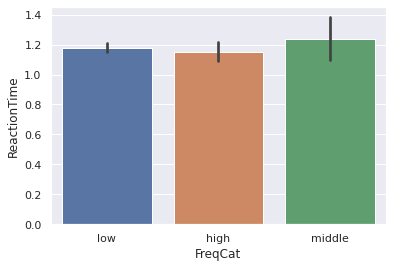

In [228]:
sns.barplot(x='FreqCat', y='ReactionTime', data = ieeg_words);

x, y = ieeg_words[ieeg_words['FreqCat'] == 'low']['ReactionTime'], ieeg_words[ieeg_words['FreqCat'] == 'middle']['ReactionTime']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['FreqCat'] == 'low']['ReactionTime'], ieeg_words[ieeg_words['FreqCat'] == 'high']['ReactionTime']
print(ttest(x,y))
x, y = ieeg_words[ieeg_words['FreqCat'] == 'high']['ReactionTime'], ieeg_words[ieeg_words['FreqCat'] == 'middle']['ReactionTime']
print(ttest(x,y))

In [203]:
ieeg_w = ieeg_words[[
    'RespCorrect', 'ReactionTime',
    'ProbeCategory', 'Trial', 'Subject', 'Length',
    'ImagCat', 'FreqCat', 'ProbeImag', 'ProbeFreq'
]]

In [214]:
%%R -i ieeg_w
comp1<-lmer('RespCorrect ~ Length + ProbeCategory + (1|Subject)', data=ieeg_w)
comp2<-lmer('RespCorrect ~ Length + ProbeCategory + ProbeFreq + (1|Subject)', data=ieeg_w)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    5 776.8720 800.8449 -383.4360 766.8720       NA NA         NA
2    6 777.8125 806.5800 -382.9063 765.8125 1.059473  1  0.3033353


In [236]:
ieeg_words[ieeg_words['Subject'] == 'D42'].groupby(['FreqCat'])[['Trial']].count()

,Trial
FreqCat,
high,8
low,46
middle,2


D32
D35
D38
D39
D42


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


D47
D53
D55
D57
D63
D69
D71
D64
D65
D73
D77


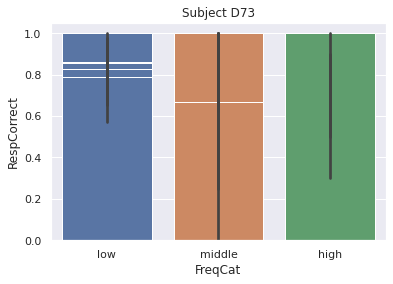

In [229]:
subjects = ieeg_words.Subject.unique()
for i in subjects:
  print(i)
  subset = ieeg_words[ieeg_words['Subject'] == i]
  x = subset[subset['FreqCat'] == 'low']['RespCorrect']
  y = subset[subset['FreqCat'] == 'middle']['RespCorrect']
  z = subset[subset['FreqCat'] == 'high']['RespCorrect']
  a = ttest(x,y)
  b = ttest(y,z)
  c = ttest(x,z)
  if a[1] < 0.05 or b[1] < 0.05 or c[1] < 0.05:
    sns.barplot(x='FreqCat', y='RespCorrect', data = subset)
    pl.title('Subject ' + i);

D32
D35
D38
D39
D42
D47
D53
D55
D57
D63
D69
D71
D64
D65
D73
D77


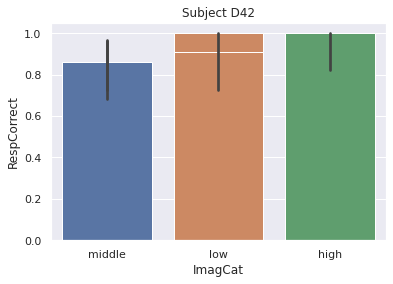

In [234]:
subjects = ieeg_words.Subject.unique()
for i in subjects:
  print(i)
  subset = ieeg_words[ieeg_words['Subject'] == i]
  x = subset[subset['ImagCat'] == 'low']['RespCorrect']
  y = subset[subset['ImagCat'] == 'middle']['RespCorrect']
  z = subset[subset['ImagCat'] == 'high']['RespCorrect']
  a = ttest(x,y)
  b = ttest(y,z)
  c = ttest(x,z)
  if a[1] < 0.05 or b[1] < 0.05 or c[1] < 0.05:
    sns.barplot(x='ImagCat', y='RespCorrect', data = subset)
    pl.title('Subject ' + i);

Let's look closer to stimulus category now 

In [239]:
ieeg_words.StimFreq.values[:10]

array([list([0.55, 44.0, 1.86, 0.75, 10.82]),
       list([44.0, 50.96, 0.61, 11.84, 0.55]), list([0.75, 20.94, 0.82]),
       list([2.16, 0.55, 23.88, 5.31, 0.63, 50.96, 9.96]),
       list([28.78, 2.16, 11.84]),
       list([20.16, 10.9, 5.31, 28.78, 0.63, 58.31, 44.0, 21.41, 0.75]),
       list([5.71, 0.61, 11.84, 7.18, 10.9, 1.86, 0.63, 5.31, 0.82]),
       list([1.86, 0.61, 20.16, 0.82, 7.18, 9.96, 5.31]),
       list([28.78, 0.55, 0.63, 11.84, 23.88]),
       list([0.75, 21.41, 44.0, 2.37, 5.71])], dtype=object)

In [174]:
ieeg_words.head()

,block,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,stimulusSounds_name,...,Length,Words,Nonwords,Environment,ProbeFreq,ProbeImag,StimFreq,StimImag,FreqCat,ImagCat
618,1,1.314829,No,1,"[46, 36, 42, 34, 29]",0,2,words,2,"[tunic, madam, quota, glacier, comic]",...,5,1,0,0,0.63,4.7,"[0.55, 44.0, 1.86, 0.75, 10.82]","[5.6, 5.6, 3.8, 6.6, 5.4]",low,middle
619,1,0.894159,Yes,1,"[36, 33, 28, 27, 46]",1,3,words,3,"[madam, duty, cherub, chapter, tunic]",...,5,1,0,0,11.84,4.9,"[44.0, 50.96, 0.61, 11.84, 0.55]","[5.6, 4.0, 3.5, 4.9, 5.6]",low,middle
621,1,0.942509,Yes,1,"[34, 43, 41]",1,17,words,5,"[glacier, rabbit, porridge]",...,3,1,0,0,0.82,5.1,"[0.75, 20.94, 0.82]","[6.6, 6.8, 5.1]",low,middle
623,1,1.211378,Yes,0,"[31, 46, 48, 45, 26, 33, 39]",0,4,words,7,"[cushion, tunic, vision, topic, chalice, duty,...",...,7,1,0,0,0.61,3.5,"[2.16, 0.55, 23.88, 5.31, 0.63, 50.96, 9.96]","[6.1, 5.6, 5.2, 3.1, 4.7, 4.0, 6.3]",low,low
624,1,2.051226,No,1,"[38, 31, 27]",0,2,words,8,"[member, cushion, chapter]",...,3,1,0,0,0.63,4.7,"[28.78, 2.16, 11.84]","[4.3, 6.1, 4.9]",low,middle


## Combined model

In [ ]:
eeg_['Patient'] = 0
ieeg_['Patient'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
combined = pd.concat([eeg_, ieeg_])

**Line Plots Accuracy**

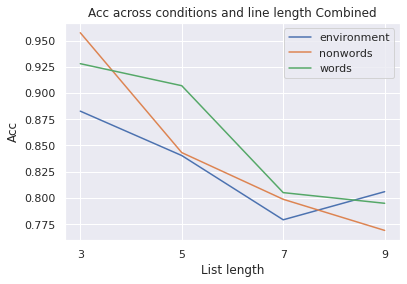

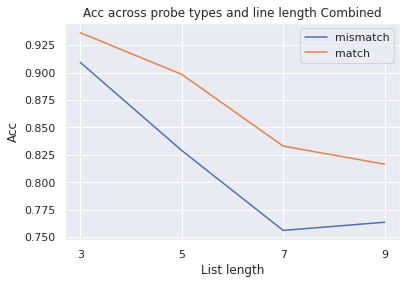

In [ ]:
pl.figure()
subset = combined.groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length Combined');

pl.figure()
subset = combined.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  if i == 1:
    name = 'match'
  elif i == 0:
    name = 'mismatch'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across probe types and line length Combined');

**Bar plots Accuracy**

Length 3 vs 5
Ttest_indResult(statistic=5.1120885428710725, pvalue=3.411816632272645e-07)
Length 5 vs 7
Ttest_indResult(statistic=-4.911606703658065, pvalue=9.547273356967004e-07)
Length 7 vs 9
Ttest_indResult(statistic=0.28754082878511633, pvalue=0.7737193214608983)


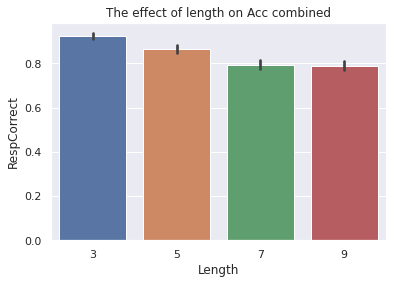

In [ ]:
sns.barplot(x='Length', y='RespCorrect', data=combined)
pl.title('The effect of length on Acc combined');

print('Length 3 vs 5')
x, y = combined[combined['Length'] == 3]['RespCorrect'], combined[combined['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = combined[combined['Length'] == 7]['RespCorrect'], combined[combined['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = combined[combined['Length'] == 7]['RespCorrect'], combined[combined['Length'] == 9]['RespCorrect']
print(ttest(x,y))

Ttest_indResult(statistic=5.864973867685747, pvalue=4.7522307295210785e-09)


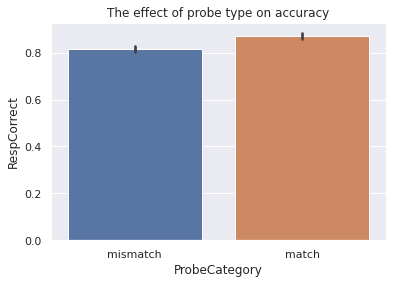

In [ ]:
ax=sns.barplot(x='ProbeCategory', y='RespCorrect', data=combined)
ax.set_xticklabels(['mismatch','match'])
pl.title('The effect of probe type on accuracy');

x,y = combined[combined['ProbeCategory'] == 1]['RespCorrect'], combined[combined['ProbeCategory'] == 0]['RespCorrect']
print(ttest(x,y))

Ttest_indResult(statistic=-6.029504148772898, pvalue=1.7562984940614059e-09)


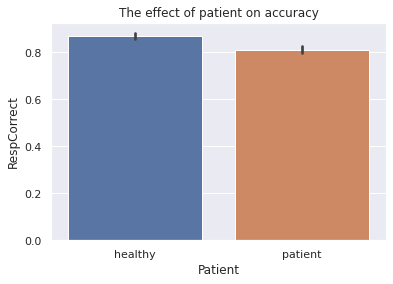

In [ ]:
ax=sns.barplot(x='Patient', y='RespCorrect', data=combined)
ax.set_xticklabels(['healthy','patient'])
pl.title('The effect of patient on accuracy');

x,y = combined[combined['Patient'] == 1]['RespCorrect'], combined[combined['Patient'] == 0]['RespCorrect']
print(ttest(x,y))

W vs NW
Ttest_indResult(statistic=1.4415238697957402, pvalue=0.14951989986684214)
W vs E
Ttest_indResult(statistic=2.674943404674826, pvalue=0.007506744136539974)
E vs NW
Ttest_indResult(statistic=-1.2347694594229524, pvalue=0.2169935351683587)


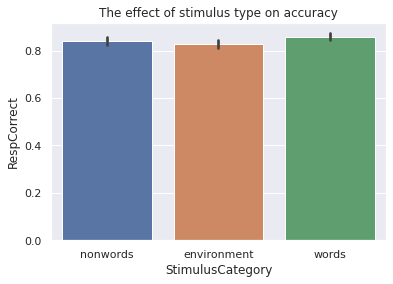

In [ ]:
sns.barplot(x='StimulusCategory', y='RespCorrect', data=combined)
pl.title('The effect of stimulus type on accuracy');

print('W vs NW')
x,y = combined[combined['StimulusCategory'] == 'words']['RespCorrect'], combined[combined['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x,y = combined[combined['StimulusCategory'] == 'words']['RespCorrect'], combined[combined['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x,y = combined[combined['StimulusCategory'] == 'environment']['RespCorrect'], combined[combined['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))

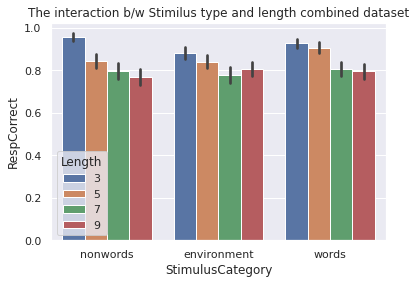

In [ ]:
sns.barplot(x='StimulusCategory', y='RespCorrect', hue='Length', data=combined_data)
pl.title('The interaction b/w Stimilus type and length combined dataset');

In [ ]:
print('Environment')
subset = combined[combined['StimulusCategory'] == 'environment']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 5]['RespCorrect'], subset[subset['Length'] == 7]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))
print('')
print('Words')
subset = combined[combined['StimulusCategory'] == 'words']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 5]['RespCorrect'], subset[subset['Length'] == 7]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))
print('')
print('Environment')
subset = combined[combined['StimulusCategory'] == 'environment']
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3]['RespCorrect'], subset[subset['Length'] == 5]['RespCorrect']
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 5]['RespCorrect'], subset[subset['Length'] == 7]['RespCorrect']
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7]['RespCorrect'], subset[subset['Length'] == 9]['RespCorrect']
print(ttest(x,y))
print('')

print('Length 3')
subset = combined[combined['Length'] == 3]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('')
print('Length 5')
subset = combined[combined['Length'] == 5]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('')
print('Length 7')
subset = combined[combined['Length'] == 7]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('')
print('Length 9')
subset = combined[combined['Length'] == 9]
print('W vs NW')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))
print('W vs E')
x, y = subset[subset['StimulusCategory'] == 'words']['RespCorrect'], subset[subset['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('E vs NW')
x, y = subset[subset['StimulusCategory'] == 'environment']['RespCorrect'], subset[subset['StimulusCategory'] == 'nonwords']['RespCorrect']
print(ttest(x,y))

Environment
Length 3 vs 5
Ttest_indResult(statistic=1.8785077111816955, pvalue=0.06062701112520789)
Length 5 vs 7
Ttest_indResult(statistic=2.3980133768151215, pvalue=0.016681498791376762)
Length 7 vs 9
Ttest_indResult(statistic=-1.0119169040671612, pvalue=0.31183922853155155)

Words
Length 3 vs 5
Ttest_indResult(statistic=1.1721119116234855, pvalue=0.2414519924722963)
Length 5 vs 7
Ttest_indResult(statistic=4.503383057154586, pvalue=7.605825661379209e-06)
Length 7 vs 9
Ttest_indResult(statistic=0.38998626212213483, pvalue=0.6966347976677277)

Environment
Length 3 vs 5
Ttest_indResult(statistic=1.8785077111816955, pvalue=0.06062701112520789)
Length 5 vs 7
Ttest_indResult(statistic=2.3980133768151215, pvalue=0.016681498791376762)
Length 7 vs 9
Ttest_indResult(statistic=-1.0119169040671612, pvalue=0.31183922853155155)

Length 3
W vs NW
Ttest_indResult(statistic=-1.94902399808226, pvalue=0.051606620889538324)
W vs E
Ttest_indResult(statistic=2.3739465091317684, pvalue=0.017809221168635113

**Model**

In [ ]:
combined.columns

Index(['block', 'StimulusCategory', 'ReactionTime', 'Resp', 'RespCorrect',
       'stimulusSounds_idx', 'ProbeCategory', 'probeSound_idx', 'Trial',
       'Subject', 'Length', 'Words', 'Nonwords', 'Environment', 'Patient'],
      dtype='object')

In [ ]:
combined_data = combined[[
    'block', 'StimulusCategory', 'ReactionTime', 'Resp', 'RespCorrect',
       'ProbeCategory', 'Trial', 'Subject', 'Length', 
       'Words', 'Nonwords', 'Environment', 'Patient'
]]

In [ ]:
%%R -i combined_data
comp1<-lmer('RespCorrect ~ Patient + ProbeCategory + StimulusCategory + Length + StimulusCategory:Length + (1|Subject)', data=combined_data)
comp2<-lmer('RespCorrect ~ Patient + ProbeCategory + StimulusCategory + Length + StimulusCategory:Length + ProbeCategory:StimulusCategory + (1|Subject)', data=combined_data)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1   10 4426.047 4492.450 -2203.024 4406.047       NA NA         NA
2   12 4424.987 4504.671 -2200.494 4400.987 5.059787  2 0.07966751


In [ ]:
model = Lmer(
    'RespCorrect ~ Patient + ProbeCategory + StimulusCategory + Length + StimulusCategory:Length + (1|Subject)',
    data = combined_data
)
model.fit()

Formula: RespCorrect~Patient+ProbeCategory+StimulusCategory+Length+StimulusCategory:Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5655	 Groups: {'Subject': 30.0}

Log-likelihood: -2235.452 	 AIC: 4470.904

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.127  0.357

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.913,0.863,0.964,0.026,916.953,35.634,0.000,***
Patient,-0.059,-0.086,-0.031,0.014,27.142,-4.146,0.000,***
ProbeCategory,0.057,0.038,0.075,0.009,5618.464,5.977,0.000,***
StimulusCategorynonwords,0.111,0.045,0.176,0.033,5618.652,3.317,0.001,***
StimulusCategorywords,0.095,0.029,0.160,0.033,5618.621,2.845,0.004,**
Length,-0.015,-0.022,-0.007,0.004,5618.664,-3.959,0.000,***
StimulusCategorynonwords:Length,-0.016,-0.026,-0.006,0.005,5618.696,-3.050,0.002,**
StimulusCategorywords:Length,-0.010,-0.021,-0.000,0.005,5618.584,-2.014,0.044,*
